In [ ]:
import math
import numpy as np
import keras_tuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from sklearn.model_selection import train_test_split

In [ ]:
images = np.load("A1/data/images.npy")
labels = np.load("A1/data/labels.npy")

num_classes = len(np.unique(labels[:,0]))

In [ ]:
# Define the function to map (hour, minute) tuples to float values upto 
def time_to_polar(row):
    minute_cosine = math.cos(row[1] * 2 * math.pi / 60)
    minute_sine = math.sin(row[1] * 2 * math.pi / 60)
    return [minute_cosine, minute_sine]

img_rows = images.shape[1]
img_cols = images.shape[2]

In [ ]:
images = images.astype('float32')/255.0

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=42) 
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=33) 


y_train_hours = keras.utils.to_categorical(y_train[:,0], num_classes)
y_train_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_train)


y_test_hours = keras.utils.to_categorical(y_test[:,0], num_classes)
y_test_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_test)


y_val_hours = keras.utils.to_categorical(y_val[:,0], num_classes)
y_val_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_val)


print(y_train_hours.shape)
print(y_train_minutes.shape)

(14400, 12)
(14400, 2)


In [ ]:
batch_size = 64
epochs = 500

if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print(x_val.shape)

(1800, 75, 75, 1)


In [ ]:
def build_model(input_shape):
    input_ = keras.layers.Input(shape=x_train.shape[1:])

    # convolutional layers
    c1 = keras.layers.Conv2D(32, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(input_)
    m1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(c1)
    b1 = keras.layers.BatchNormalization()(m1)

    #2nd layers
    c2 = keras.layers.Conv2D(64, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b1)
    d2=  keras.layers.Dropout(0.10)(c2)
    m2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d2)
    b2 = keras.layers.BatchNormalization()(m2)

    #3rd layers
    c3 = keras.layers.Conv2D(128, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b2)
    d3 = keras.layers.Dropout(0.10)(c3)
    m3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d3)
    b3 = keras.layers.BatchNormalization()(m3)

                            
    #4th layers
    c4 = keras.layers.Conv2D(256, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b3)
    d4 = keras.layers.Dropout(0.10)(c4)
    m4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d4)
    b4 = keras.layers.BatchNormalization()(m4)
                            

    #final layer begins
    f = keras.layers.Flatten()(b4)
                           
                           
    #for hours final layers
    dense_hour1 = keras.layers.Dense(128, activation='relu')(f)
    dense_dropout1 = keras.layers.Dropout(0.10)(dense_hour1)
    final_hour = keras.layers.Dense(num_classes, activation='softmax')(dense_dropout1)


    # for minutes final layers
    minute_dense1 = keras.layers.Dense(512, activation='relu')(f)

    minute_dropout1 = keras.layers.Dropout(0.5)(minute_dense1)
    minute_dense2 = keras.layers.Dense(128, activation='relu')(minute_dropout1)
    minute_dropout2 =  keras.layers.Dropout(0.3)(minute_dense2)
        
    minute_dense3 = keras.layers.Dense(64, activation='relu')(minute_dropout2)
    minute_dropout3 =  keras.layers.Dropout(0.1)(minute_dense3)

    final_minute = keras.layers.Dense(2, activation='tanh')(minute_dropout3)
                          
    model = keras.Model(inputs=input_, outputs=[final_hour, final_minute])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3, 
                                                  weight_decay=1e-5), 
                  loss=['categorical_crossentropy', 'huber'], metrics=["accuracy", 'mae'])

    return model

In [ ]:
model = build_model(input_shape=input_shape)
model.summary()

/local/s3777103/IDL-11/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-05 15:41:49.236774: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22461 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:3b:00.0, compute capability: 8.6
2024-11-05 15:41:49.237710: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22461 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 75, 75, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 75, 75,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 37, 37,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 37, 37,    │        128 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 37, 37,    │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 37, 37,    │          0 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 18, 18,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 18, 18,    │        256 │ max_pooling2d_1[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 18, 18,    │     73,856 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 18, 18,    │          0 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 9, 9, 128) │          0 │ dropout_1[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 128) │        512 │ max_pooling2d_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 9, 9, 256) │    295,168 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 9, 9, 256) │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 4, 4, 256) │          0 │ dropout_2[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 256) │      1,024 │ max_pooling2d_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4096)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │  2,097,664 │ flatten[0][0]   

 Total params: 3,087,438 (11.78 MB)

 Trainable params: 3,086,478 (11.77 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Initialize EarlyStopping with patience
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=50,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
)


history = model.fit(x_train, [y_train_hours, y_train_minutes],
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_val, [y_val_hours, y_val_minutes]),
                callbacks=[early_stopping, reduce_lr]
)

Epoch 1/500


I0000 00:00:1730839335.715798    1231 service.cc:146] XLA service 0x7f0858006a20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730839335.715861    1231 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
I0000 00:00:1730839335.715869    1231 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-11-05 15:42:15.858342: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-05 15:42:16.324271: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-11-05 15:42:18.849574: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 4 bytes spill stores, 4 bytes spill loads

2024-11-05 15:42:20.682884: I externa

 20/225 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - dense_1_accuracy: 0.0915 - dense_1_loss: 3.4887 - dense_5_loss: 0.5057 - dense_5_mae: 0.8757 - loss: 3.9945

I0000 00:00:1730839348.674917    1231 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


223/225 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - dense_1_accuracy: 0.0858 - dense_1_loss: 2.6768 - dense_5_loss: 0.5353 - dense_5_mae: 0.9040 - loss: 3.2121

2024-11-05 15:42:39.045206: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_341', 8 bytes spill stores, 8 bytes spill loads



225/225 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - dense_1_accuracy: 0.0858 - dense_1_loss: 2.6747 - dense_5_loss: 0.5350 - dense_5_mae: 0.9037 - loss: 3.2097 - val_dense_1_accuracy: 0.0739 - val_dense_1_loss: 2.4978 - val_dense_5_loss: 0.3699 - val_dense_5_mae: 0.7378 - val_loss: 2.8714 - learning_rate: 0.0010
Epoch 2/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - dense_1_accuracy: 0.1318 - dense_1_loss: 2.3485 - dense_5_loss: 0.3073 - dense_5_mae: 0.6570 - loss: 2.6559 - val_dense_1_accuracy: 0.0956 - val_dense_1_loss: 2.4698 - val_dense_5_loss: 0.2688 - val_dense_5_mae: 0.6529 - val_loss: 2.7415 - learning_rate: 0.0010
Epoch 3/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - dense_1_accuracy: 0.2349 - dense_1_loss: 1.9902 - dense_5_loss: 0.2136 - dense_5_mae: 0.5543 - loss: 2.2038 - val_dense_1_accuracy: 0.2383 - val_dense_1_loss: 1.9608 - val_dense_5_loss: 0.2219 - val_dense_5_mae: 0.5929 - val_loss: 2.1872 - learning_rate: 0.0010
Epoch 4/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - dens

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

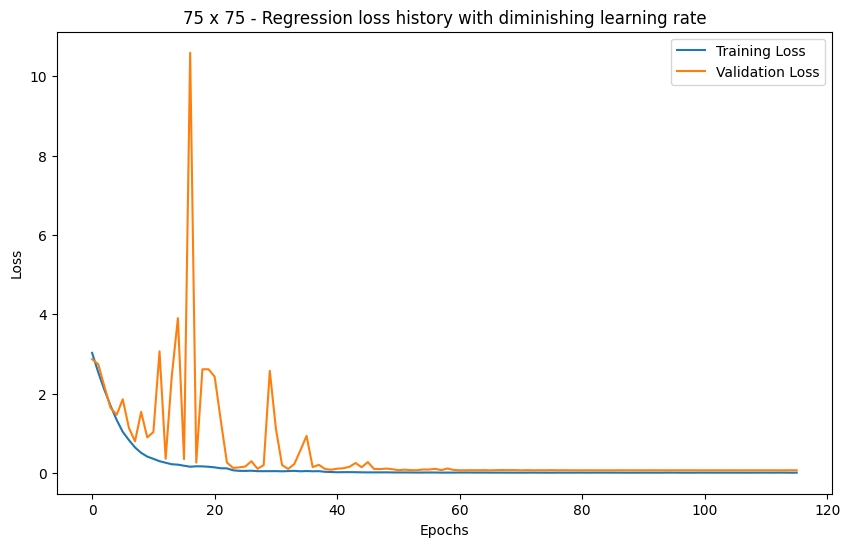

In [ ]:
# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'{img_rows} x {img_cols} - Regression loss history with diminishing learning rate')
plt.legend()
plt.show()
plt.close()

In [ ]:
y_pred = model.predict(x_test)

2024-11-05 15:48:27.512088: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 16 bytes spill stores, 16 bytes spill loads



57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step


In [ ]:
y_pred_hours = np.argmax(y_pred[0], axis=1)
y_test_hours = y_test[:,0]

abs_hr = np.abs(y_pred_hours - y_test_hours)
cse_hr = np.minimum(abs_hr, 12 - abs_hr)

Text(0.5, 1.0, 'Scatter for hour - Classification')

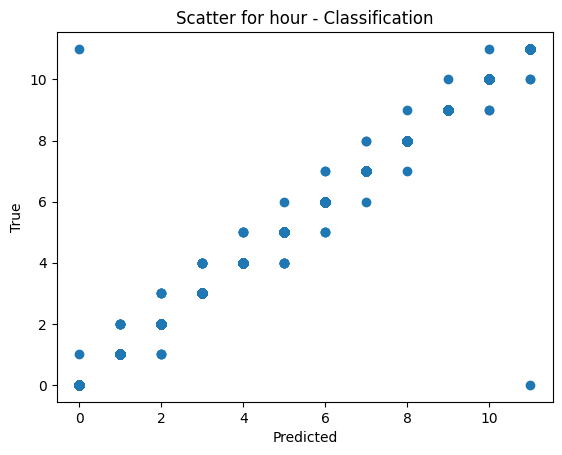

In [ ]:
plt.scatter(y_pred_hours, y_test_hours)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for hour - Classification')

In [ ]:
y_test_minutes =  y_test[:,1]
y_pred_mins = (np.arctan2(y_pred[1][:,1], y_pred[1][:,0]) % (2 * np.pi)) *  60 / (2 * np.pi)


abs_mins = abs(y_pred_mins-y_test[:,1])
cse_min = np.minimum(abs_mins, 60. - abs_mins)

Text(0.5, 1.0, 'Scatter for minutes - Polar')

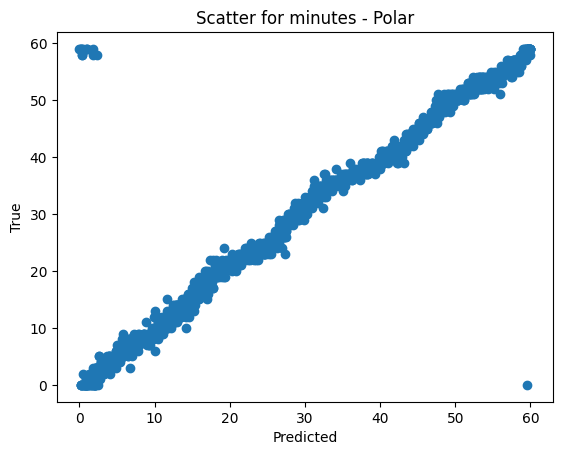

In [ ]:
plt.scatter(y_pred_mins, y_test[:,1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for minutes - Polar')

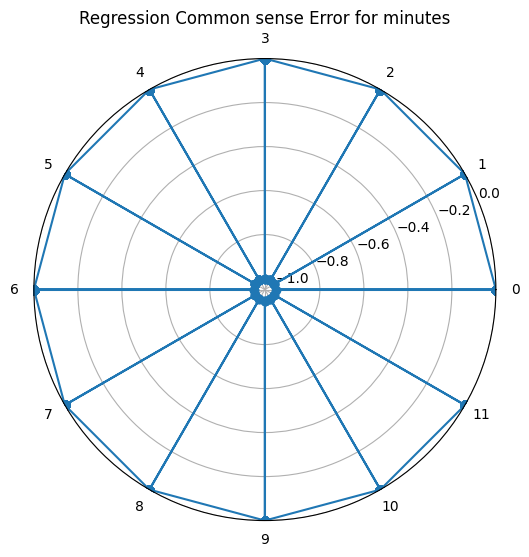

In [ ]:
sorted_indices_hr = np.argsort(y_test_hours)
sorted_y_test_hr = y_test_hours[sorted_indices_hr]

# Create polar plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_hr/12, -cse_hr[sorted_indices_hr], marker='o')

# Add title and show plot
ax.set_title("Regression Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 12, endpoint=False)  # 12 hours around the clock
ax.set_xticks(theta_ticks)

ax.set_xticklabels(range(12))

plt.show()

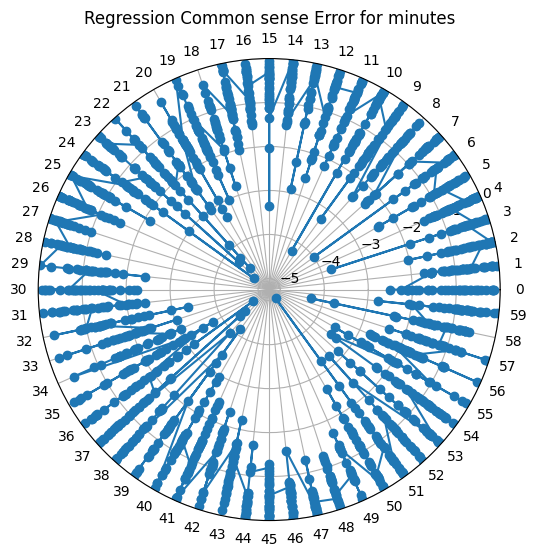

In [ ]:
sorted_indices_min = np.argsort(y_test_minutes)
sorted_y_test_min = y_test_minutes[sorted_indices_min]

# Create polar plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_min/60, -cse_min[sorted_indices_min], marker='o')

# Add title and show plot
ax.set_title("Regression Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 60, endpoint=False)  # 60 mins around the clock
ax.set_xticks(theta_ticks)

ax.set_xticklabels(range(60))

plt.show()

In [ ]:
import math
import numpy as np
import keras_tuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from sklearn.model_selection import train_test_split

In [ ]:
images = np.load("A1/data/images_150.npy")
labels = np.load("A1/data/labels_150.npy")

num_classes = len(np.unique(labels[:,0]))

In [ ]:
# Define the function to map (hour, minute) tuples to float values upto 
def time_to_polar(row):
    minute_cosine = math.cos(row[1] * 2 * math.pi / 60)
    minute_sine = math.sin(row[1] * 2 * math.pi / 60)
    return [minute_cosine, minute_sine]

img_rows = images.shape[1]
img_cols = images.shape[2]

In [ ]:
images = images.astype('float32')/255.0

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=42) 
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=33) 


y_train_hours = keras.utils.to_categorical(y_train[:,0], num_classes)
y_train_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_train)


y_test_hours = keras.utils.to_categorical(y_test[:,0], num_classes)
y_test_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_test)


y_val_hours = keras.utils.to_categorical(y_val[:,0], num_classes)
y_val_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_val)


print(y_train_hours.shape)
print(y_train_minutes.shape)

(14400, 12)
(14400, 2)


In [ ]:
batch_size = 64
epochs = 500

if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print(x_val.shape)

(1800, 150, 150, 1)


In [ ]:
def build_model(input_shape):
    input_ = keras.layers.Input(shape=x_train.shape[1:])

    # convolutional layers
    c1 = keras.layers.Conv2D(32, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(input_)
    m1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(c1)
    b1 = keras.layers.BatchNormalization()(m1)

    #2nd layers
    c2 = keras.layers.Conv2D(64, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b1)
    d2=  keras.layers.Dropout(0.10)(c2)
    m2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d2)
    b2 = keras.layers.BatchNormalization()(m2)

    #3rd layers
    c3 = keras.layers.Conv2D(128, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b2)
    d3 = keras.layers.Dropout(0.10)(c3)
    m3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d3)
    b3 = keras.layers.BatchNormalization()(m3)

                            
    #4th layers
    c4 = keras.layers.Conv2D(256, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b3)
    d4 = keras.layers.Dropout(0.10)(c4)
    m4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d4)
    b4 = keras.layers.BatchNormalization()(m4)
                            

    #final layer begins
    f = keras.layers.Flatten()(b4)
                           
                           
    #for hours final layers
    dense_hour1 = keras.layers.Dense(128, activation='relu')(f)
    dense_dropout1 = keras.layers.Dropout(0.10)(dense_hour1)
    final_hour = keras.layers.Dense(num_classes, activation='softmax')(dense_dropout1)


    # for minutes final layers
    minute_dense1 = keras.layers.Dense(512, activation='relu')(f)

    minute_dropout1 = keras.layers.Dropout(0.5)(minute_dense1)
    minute_dense2 = keras.layers.Dense(128, activation='relu')(minute_dropout1)
    minute_dropout2 =  keras.layers.Dropout(0.3)(minute_dense2)
        
    minute_dense3 = keras.layers.Dense(64, activation='relu')(minute_dropout2)
    minute_dropout3 =  keras.layers.Dropout(0.1)(minute_dense3)

    final_minute = keras.layers.Dense(2, activation='tanh')(minute_dropout3)
                          
    model = keras.Model(inputs=input_, outputs=[final_hour, final_minute])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3, 
                                                  weight_decay=1e-5), 
                  loss=['categorical_crossentropy', 'huber'], metrics=["accuracy", 'mae'])

    model.summary()
    return model

In [ ]:
model = build_model(input_shape=input_shape)

/local/s3777103/IDL-11/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 150, 150,  │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 75, 75,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │        128 │ max_pooling2d_4[… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 75, 75,    │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 75, 75,    │          0 │ conv2d_5[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 37, 37,    │          0 │ dropout_7[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 37, 37,    │        256 │ max_pooling2d_5[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 37, 37,    │     73,856 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 37, 37,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 18, 18,    │          0 │ dropout_8[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 18, 18,    │        512 │ max_pooling2d_6[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 18, 18,    │    295,168 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 18, 18,    │          0 │ conv2d_7[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 9, 9, 256) │          0 │ dropout_9[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 256) │      1,024 │ max_pooling2d_7[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 20736)     │          0 │ batch_normalizat

 Total params: 13,737,038 (52.40 MB)

 Trainable params: 13,736,078 (52.40 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Initialize EarlyStopping with patience
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=50,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
)


history = model.fit(x_train, [y_train_hours, y_train_minutes],
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_val, [y_val_hours, y_val_minutes]),
                callbacks=[early_stopping, reduce_lr]
)

Epoch 1/500


2024-11-05 16:40:38.498570: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 4 bytes spill stores, 4 bytes spill loads

2024-11-05 16:40:40.551602: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 108 bytes spill stores, 108 bytes spill loads

2024-11-05 16:40:40.609346: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 108 bytes spill stores, 108 bytes spill loads

2024-11-05 16:40:40.739966: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 168 bytes spill stores, 168 bytes spill loads



225/225 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - dense_11_loss: 0.6081 - dense_11_mae: 0.9815 - dense_7_accuracy: 0.0870 - dense_7_loss: 3.1385 - loss: 3.7466 - val_dense_11_loss: 0.6222 - val_dense_11_mae: 0.9971 - val_dense_7_accuracy: 0.0822 - val_dense_7_loss: 2.4852 - val_loss: 3.1071 - learning_rate: 0.0010
Epoch 2/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - dense_11_loss: 0.6217 - dense_11_mae: 0.9951 - dense_7_accuracy: 0.0829 - dense_7_loss: 2.4851 - loss: 3.1068 - val_dense_11_loss: 0.6222 - val_dense_11_mae: 0.9971 - val_dense_7_accuracy: 0.0739 - val_dense_7_loss: 2.4850 - val_loss: 3.1069 - learning_rate: 0.0010
Epoch 3/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - dense_11_loss: 0.6189 - dense_11_mae: 0.9923 - dense_7_accuracy: 0.0820 - dense_7_loss: 2.4851 - loss: 3.1040 - val_dense_11_loss: 0.6222 - val_dense_11_mae: 0.9971 - val_dense_7_accuracy: 0.0739 - val_dense_7_loss: 2.4851 - val_loss: 3.1069 - learning_rate: 0.0010
Epoch 4/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 2

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

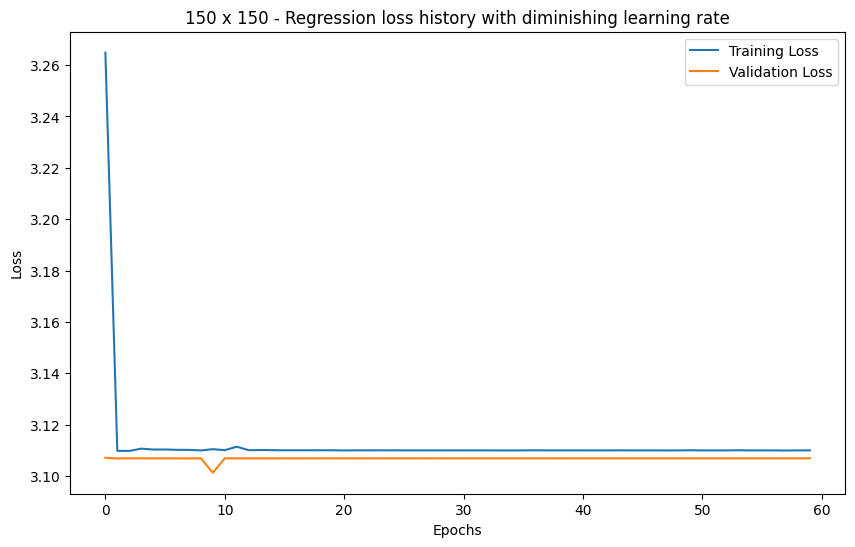

In [ ]:
# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'{img_rows} x {img_cols} - Regression loss history with diminishing learning rate')
plt.legend()
plt.show()
plt.close()

In [ ]:
y_pred = model.predict(x_test)

2024-11-05 16:45:36.985351: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 168 bytes spill stores, 168 bytes spill loads



57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step


In [ ]:
y_pred_hours = np.argmax(y_pred[0], axis=1)
y_test_hours = y_test[:,0]

abs_hr = np.abs(y_pred_hours - y_test_hours)
cse_hr = np.minimum(abs_hr, 12 - abs_hr)

Text(0.5, 1.0, 'Scatter for hour - Classification')

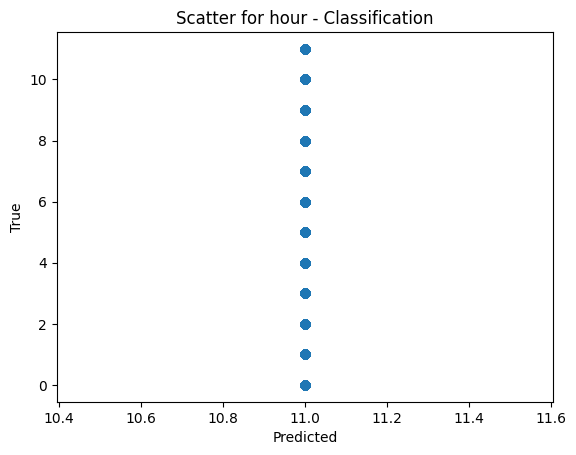

In [ ]:
plt.scatter(y_pred_hours, y_test_hours)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for hour - Classification')

In [ ]:
y_test_minutes =  y_test[:,1]
y_pred_mins = (np.arctan2(y_pred[1][:,1], y_pred[1][:,0]) % (2 * np.pi)) *  60 / (2 * np.pi)


abs_mins = abs(y_pred_mins-y_test[:,1])
cse_min = np.minimum(abs_mins, 60. - abs_mins)

Text(0.5, 1.0, 'Scatter for minutes - Polar')

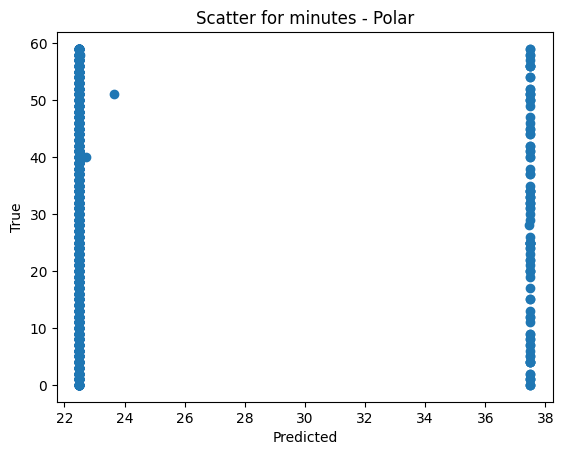

In [ ]:
plt.scatter(y_pred_mins, y_test[:,1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for minutes - Polar')

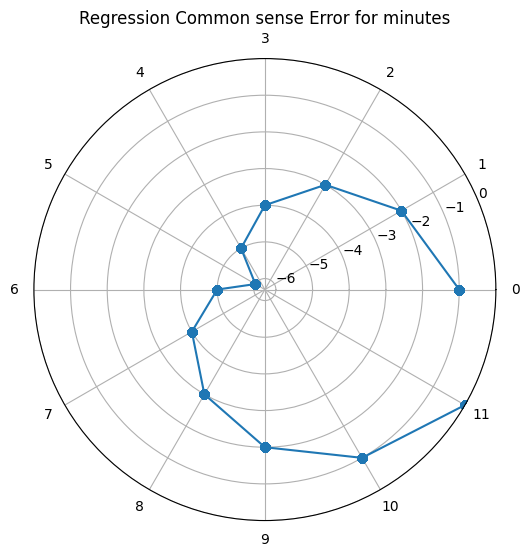

In [ ]:
sorted_indices_hr = np.argsort(y_test_hours)
sorted_y_test_hr = y_test_hours[sorted_indices_hr]

# Create polar plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_hr/12, -cse_hr[sorted_indices_hr], marker='o')

# Add title and show plot
ax.set_title("Regression Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 12, endpoint=False)  # 12 hours around the clock
ax.set_xticks(theta_ticks)

ax.set_xticklabels(range(12))

plt.show()

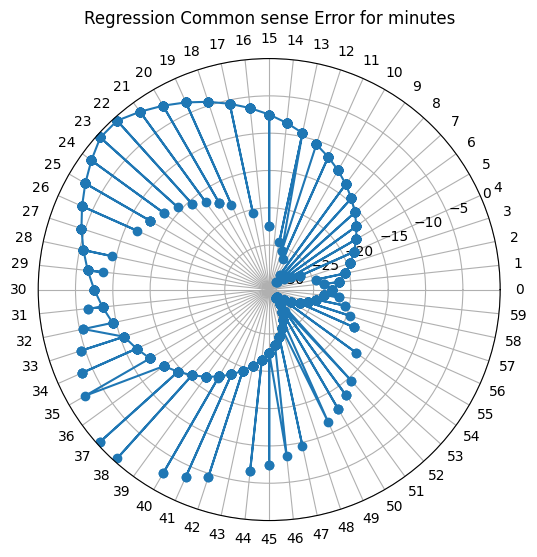

In [ ]:
sorted_indices_min = np.argsort(y_test_minutes)
sorted_y_test_min = y_test_minutes[sorted_indices_min]

# Create polar plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_min/60, -cse_min[sorted_indices_min], marker='o')

# Add title and show plot
ax.set_title("Regression Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 60, endpoint=False)  # 60 mins around the clock
ax.set_xticks(theta_ticks)

ax.set_xticklabels(range(60))

plt.show()

In [ ]:
ima

NameError: name 'ima' is not defined

In [ ]:
images[0]

array([[0.5294118 , 0.50980395, 0.54509807, ..., 0.5647059 , 0.5764706 ,
        0.5882353 ],
       [0.50980395, 0.4862745 , 0.5137255 , ..., 0.5568628 , 0.56078434,
        0.56078434],
       [0.5294118 , 0.5529412 , 0.58431375, ..., 0.6       , 0.6       ,
        0.6       ],
       ...,
       [0.24313726, 0.2901961 , 0.3882353 , ..., 0.43137255, 0.5411765 ,
        0.5058824 ],
       [0.30980393, 0.3764706 , 0.48235294, ..., 0.28235295, 0.29803923,
        0.36862746],
       [0.37254903, 0.38039216, 0.43529412, ..., 0.27450982, 0.25882354,
        0.32156864]], dtype=float32)

In [ ]:
images = np.load("A1/data/images_150.npy")
labels = np.load("A1/data/labels_150.npy")

num_classes = len(np.unique(labels[:,0]))

In [ ]:
images[0]

array([[135, 130, 139, ..., 144, 147, 150],
       [130, 124, 131, ..., 142, 143, 143],
       [135, 141, 149, ..., 153, 153, 153],
       ...,
       [ 62,  74,  99, ..., 110, 138, 129],
       [ 79,  96, 123, ...,  72,  76,  94],
       [ 95,  97, 111, ...,  70,  66,  82]], dtype=uint8)

In [ ]:
images

array([[[135, 130, 139, ..., 144, 147, 150],
        [130, 124, 131, ..., 142, 143, 143],
        [135, 141, 149, ..., 153, 153, 153],
        ...,
        [ 62,  74,  99, ..., 110, 138, 129],
        [ 79,  96, 123, ...,  72,  76,  94],
        [ 95,  97, 111, ...,  70,  66,  82]],

       [[128, 140, 147, ..., 140, 134, 134],
        [142, 141, 160, ..., 129, 122, 121],
        [138, 144, 147, ..., 120, 129, 134],
        ...,
        [ 69,  65,  69, ..., 101,  92,  90],
        [ 70,  78,  91, ..., 102,  96,  92],
        [ 74,  96, 117, ...,  99,  92,  82]],

       [[128, 125, 116, ..., 153, 151, 150],
        [148, 148, 142, ..., 162, 163, 164],
        [152, 153, 148, ..., 157, 154, 151],
        ...,
        [138, 136, 147, ...,  82,  70,  77],
        [127, 130, 129, ...,  99,  91,  98],
        [142, 135, 124, ..., 102,  94,  98]],

       ...,

       [[129, 122, 126, ..., 149, 150, 153],
        [134, 125, 124, ..., 144, 143, 144],
        [141, 136, 139, ..., 151, 150, 151

In [ ]:
images.shape

(18000, 150, 150)

Restarted .venv (Python 3.10.7)

No kernel connected

Connected to .venv (Python 3.10.7)

In [ ]:
import math
import numpy as np
import keras_tuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from sklearn.model_selection import train_test_split

2024-11-05 17:36:22.399723: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-05 17:36:22.415651: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-05 17:36:22.436592: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-05 17:36:22.442735: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-05 17:36:22.458441: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
images = np.load("A1/data/images_150.npy")
labels = np.load("A1/data/labels_150.npy")

num_classes = len(np.unique(labels[:,0]))

In [ ]:
num_classes

12

In [ ]:
images

array([[[135, 130, 139, ..., 144, 147, 150],
        [130, 124, 131, ..., 142, 143, 143],
        [135, 141, 149, ..., 153, 153, 153],
        ...,
        [ 62,  74,  99, ..., 110, 138, 129],
        [ 79,  96, 123, ...,  72,  76,  94],
        [ 95,  97, 111, ...,  70,  66,  82]],

       [[128, 140, 147, ..., 140, 134, 134],
        [142, 141, 160, ..., 129, 122, 121],
        [138, 144, 147, ..., 120, 129, 134],
        ...,
        [ 69,  65,  69, ..., 101,  92,  90],
        [ 70,  78,  91, ..., 102,  96,  92],
        [ 74,  96, 117, ...,  99,  92,  82]],

       [[128, 125, 116, ..., 153, 151, 150],
        [148, 148, 142, ..., 162, 163, 164],
        [152, 153, 148, ..., 157, 154, 151],
        ...,
        [138, 136, 147, ...,  82,  70,  77],
        [127, 130, 129, ...,  99,  91,  98],
        [142, 135, 124, ..., 102,  94,  98]],

       ...,

       [[129, 122, 126, ..., 149, 150, 153],
        [134, 125, 124, ..., 144, 143, 144],
        [141, 136, 139, ..., 151, 150, 151

In [ ]:
labels

array([[ 0,  0],
       [ 0,  0],
       [ 0,  0],
       ...,
       [11, 59],
       [11, 59],
       [11, 59]])

In [ ]:
# Define the function to map (hour, minute) tuples to float values upto 
def time_to_polar(row):
    minute_cosine = math.cos(row[1] * 2 * math.pi / 60)
    minute_sine = math.sin(row[1] * 2 * math.pi / 60)
    return [minute_cosine, minute_sine]

img_rows = images.shape[1]
img_cols = images.shape[2]

In [ ]:
images = images.astype('float32')/255.0

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=42) 
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=33) 


y_train_hours = keras.utils.to_categorical(y_train[:,0], num_classes)
y_train_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_train)


y_test_hours = keras.utils.to_categorical(y_test[:,0], num_classes)
y_test_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_test)


y_val_hours = keras.utils.to_categorical(y_val[:,0], num_classes)
y_val_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_val)


print(y_train_hours.shape)
print(y_train_minutes.shape)

(14400, 12)
(14400, 2)


In [ ]:
batch_size = 64
epochs = 500

if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print(x_val.shape)

(1800, 150, 150, 1)


In [ ]:
def build_model(input_shape):
    input_ = keras.layers.Input(shape=x_train.shape[1:])

    # convolutional layers
    c1 = keras.layers.Conv2D(32, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(input_)
    m1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(c1)
    b1 = keras.layers.BatchNormalization()(m1)

    #2nd layers
    c2 = keras.layers.Conv2D(64, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b1)
    d2=  keras.layers.Dropout(0.10)(c2)
    m2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d2)
    b2 = keras.layers.BatchNormalization()(m2)

    #3rd layers
    c3 = keras.layers.Conv2D(128, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b2)
    d3 = keras.layers.Dropout(0.10)(c3)
    m3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d3)
    b3 = keras.layers.BatchNormalization()(m3)

                            
    #4th layers
    c4 = keras.layers.Conv2D(256, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b3)
    d4 = keras.layers.Dropout(0.10)(c4)
    m4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d4)
    b4 = keras.layers.BatchNormalization()(m4)
                            

    #final layer begins
    f = keras.layers.Flatten()(b4)
                           
                           
    #for hours final layers
    dense_hour1 = keras.layers.Dense(128, activation='relu')(f)
    dense_dropout1 = keras.layers.Dropout(0.10)(dense_hour1)
    final_hour = keras.layers.Dense(num_classes, activation='softmax')(dense_dropout1)


    # for minutes final layers
    minute_dense1 = keras.layers.Dense(512, activation='relu')(f)

    minute_dropout1 = keras.layers.Dropout(0.5)(minute_dense1)
    minute_dense2 = keras.layers.Dense(128, activation='relu')(minute_dropout1)
    minute_dropout2 =  keras.layers.Dropout(0.3)(minute_dense2)
        
    minute_dense3 = keras.layers.Dense(64, activation='relu')(minute_dropout2)
    minute_dropout3 =  keras.layers.Dropout(0.1)(minute_dense3)

    final_minute = keras.layers.Dense(2, activation='tanh')(minute_dropout3)
                          
    model = keras.Model(inputs=input_, outputs=[final_hour, final_minute])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3, 
                                                  weight_decay=1e-5), 
                  loss=['categorical_crossentropy', 'huber'], metrics=["accuracy", 'mae'])

    model.summary()
    return model

In [ ]:
model = build_model(input_shape=input_shape)

/local/s3777103/IDL-11/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-05 17:37:57.196958: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1015 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:3b:00.0, compute capability: 8.6
2024-11-05 17:37:57.197666: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22204 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 150, 150,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 75, 75,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 75, 75,    │        128 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 75, 75,    │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 75, 75,    │          0 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 37, 37,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 37, 37,    │        256 │ max_pooling2d_1[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 37, 37,    │     73,856 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 37, 37,    │          0 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 18, 18,    │          0 │ dropout_1[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 18, 18,    │        512 │ max_pooling2d_2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 18, 18,    │    295,168 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 18, 18,    │          0 │ conv2d_3[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 9, 9, 256) │          0 │ dropout_2[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 256) │      1,024 │ max_pooling2d_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 20736)     │          0 │ batch_normalizat

 Total params: 13,737,038 (52.40 MB)

 Trainable params: 13,736,078 (52.40 MB)

 Non-trainable params: 960 (3.75 KB)

Connected to .venv (Python 3.10.7)

In [ ]:
import math
import numpy as np
import keras_tuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from sklearn.model_selection import train_test_split

2024-11-06 03:24:44.568001: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-06 03:24:44.588893: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 03:24:44.611422: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 03:24:44.618357: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 03:24:44.637427: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
images = np.load("A1/data/images.npy")
labels = np.load("A1/data/labels.npy")

num_classes = len(np.unique(labels[:,0]))

In [ ]:
# Define the function to map (hour, minute) tuples to float values upto 
def time_to_polar(row):
    minute_cosine = math.cos(row[1] * 2 * math.pi / 60)
    minute_sine = math.sin(row[1] * 2 * math.pi / 60)
    return [minute_cosine, minute_sine]

img_rows = images.shape[1]
img_cols = images.shape[2]

In [ ]:
images = images.astype('float32')/255.0

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=42) 
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=33) 


y_train_hours = keras.utils.to_categorical(y_train[:,0], num_classes)
y_train_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_train)


y_test_hours = keras.utils.to_categorical(y_test[:,0], num_classes)
y_test_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_test)


y_val_hours = keras.utils.to_categorical(y_val[:,0], num_classes)
y_val_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_val)


print(y_train_hours.shape)
print(y_train_minutes.shape)

(14400, 12)
(14400, 2)


In [ ]:
batch_size = 64
epochs = 500

if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print(x_val.shape)

(1800, 75, 75, 1)


In [ ]:
def build_model(input_shape):
    input_ = keras.layers.Input(shape=x_train.shape[1:])

    # convolutional layers
    c1 = keras.layers.Conv2D(32, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(input_)
    m1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(c1)
    b1 = keras.layers.BatchNormalization()(m1)

    #2nd layers
    c2 = keras.layers.Conv2D(64, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b1)
    d2=  keras.layers.Dropout(0.10)(c2)
    m2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d2)
    b2 = keras.layers.BatchNormalization()(m2)

    #3rd layers
    c3 = keras.layers.Conv2D(128, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b2)
    d3 = keras.layers.Dropout(0.10)(c3)
    m3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d3)
    b3 = keras.layers.BatchNormalization()(m3)

                            
    #4th layers
    c4 = keras.layers.Conv2D(256, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b3)
    d4 = keras.layers.Dropout(0.10)(c4)
    m4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d4)
    b4 = keras.layers.BatchNormalization()(m4)
                            

    #final layer begins
    f = keras.layers.Flatten()(b4)
                           
                           
    #for hours final layers
    dense_hour1 = keras.layers.Dense(128, activation='relu')(f)
    dense_dropout1 = keras.layers.Dropout(0.10)(dense_hour1)
    final_hour = keras.layers.Dense(num_classes, activation='softmax')(dense_dropout1)


    # for minutes final layers
    minute_dense1 = keras.layers.Dense(512, activation='relu')(f)

    minute_dropout1 = keras.layers.Dropout(0.5)(minute_dense1)
    minute_dense2 = keras.layers.Dense(128, activation='relu')(minute_dropout1)
    minute_dropout2 =  keras.layers.Dropout(0.3)(minute_dense2)
        
    minute_dense3 = keras.layers.Dense(64, activation='relu')(minute_dropout2)
    minute_dropout3 =  keras.layers.Dropout(0.1)(minute_dense3)

    final_minute = keras.layers.Dense(2, activation='tanh')(minute_dropout3)
                          
    model = keras.Model(inputs=input_, outputs=[final_hour, final_minute])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3, 
                                                  weight_decay=1e-5), 
                  loss=['categorical_crossentropy', 'huber'], metrics=["accuracy", 'mae'])

    model.summary()
    return model

In [ ]:
model = build_model(input_shape=input_shape)

/local/s3777103/IDL-11/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-06 03:24:50.530844: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22461 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:3b:00.0, compute capability: 8.6
2024-11-06 03:24:50.531445: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 1525 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 75, 75, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 75, 75,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 37, 37,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 37, 37,    │        128 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 37, 37,    │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 37, 37,    │          0 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 18, 18,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 18, 18,    │        256 │ max_pooling2d_1[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 18, 18,    │     73,856 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 18, 18,    │          0 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 9, 9, 128) │          0 │ dropout_1[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 128) │        512 │ max_pooling2d_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 9, 9, 256) │    295,168 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 9, 9, 256) │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 4, 4, 256) │          0 │ dropout_2[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 256) │      1,024 │ max_pooling2d_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4096)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │  2,097,664 │ flatten[0][0]   

 Total params: 3,087,438 (11.78 MB)

 Trainable params: 3,086,478 (11.77 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Initialize EarlyStopping with patience
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=50,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
)


history = model.fit(x_train, [y_train_hours, y_train_minutes],
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_val, [y_val_hours, y_val_minutes]),
                callbacks=[early_stopping, reduce_lr]
)

Epoch 1/500


I0000 00:00:1730881496.223930     917 service.cc:146] XLA service 0x7fd740000fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730881496.223994     917 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
I0000 00:00:1730881496.224006     917 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-11-06 03:24:56.380683: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-06 03:24:56.926079: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-11-06 03:24:59.302422: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 4 bytes spill stores, 4 bytes spill loads

2024-11-06 03:25:01.539429: I externa

 20/225 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - dense_1_accuracy: 0.0635 - dense_1_loss: 3.5737 - dense_5_loss: 0.5255 - dense_5_mae: 0.8876 - loss: 4.0991

I0000 00:00:1730881510.455955     917 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


221/225 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - dense_1_accuracy: 0.0770 - dense_1_loss: 2.7006 - dense_5_loss: 0.5903 - dense_5_mae: 0.9610 - loss: 3.2908

2024-11-06 03:25:21.692164: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_341', 8 bytes spill stores, 8 bytes spill loads



225/225 ━━━━━━━━━━━━━━━━━━━━ 32s 64ms/step - dense_1_accuracy: 0.0771 - dense_1_loss: 2.6969 - dense_5_loss: 0.5907 - dense_5_mae: 0.9616 - loss: 3.2876 - val_dense_1_accuracy: 0.0850 - val_dense_1_loss: 2.5585 - val_dense_5_loss: 0.6222 - val_dense_5_mae: 0.9904 - val_loss: 3.1725 - learning_rate: 0.0010
Epoch 2/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - dense_1_accuracy: 0.0818 - dense_1_loss: 2.4850 - dense_5_loss: 0.6322 - dense_5_mae: 1.0092 - loss: 3.1172 - val_dense_1_accuracy: 0.0844 - val_dense_1_loss: 2.4916 - val_dense_5_loss: 0.6222 - val_dense_5_mae: 0.9904 - val_loss: 3.1073 - learning_rate: 0.0010
Epoch 3/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - dense_1_accuracy: 0.0855 - dense_1_loss: 2.4849 - dense_5_loss: 0.6268 - dense_5_mae: 1.0021 - loss: 3.1117 - val_dense_1_accuracy: 0.0811 - val_dense_1_loss: 2.4849 - val_dense_5_loss: 0.6222 - val_dense_5_mae: 0.9904 - val_loss: 3.1020 - learning_rate: 0.0010
Epoch 4/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - dens

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

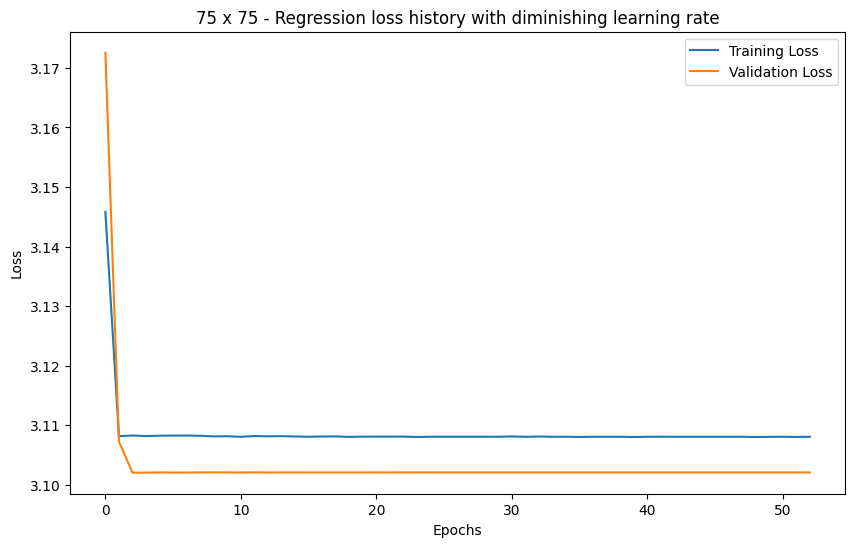

In [ ]:
# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'{img_rows} x {img_cols} - Regression loss history with diminishing learning rate')
plt.legend()
plt.show()
plt.close()

In [ ]:
y_pred = model.predict(x_test)

2024-11-06 03:27:13.387003: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 16 bytes spill stores, 16 bytes spill loads



57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step


In [ ]:
y_pred_hours = np.argmax(y_pred[0], axis=1)
y_test_hours = y_test[:,0]

abs_hr = np.abs(y_pred_hours - y_test_hours)
cse_hr = np.minimum(abs_hr, 12 - abs_hr)

Text(0.5, 1.0, 'Scatter for hour - Classification')

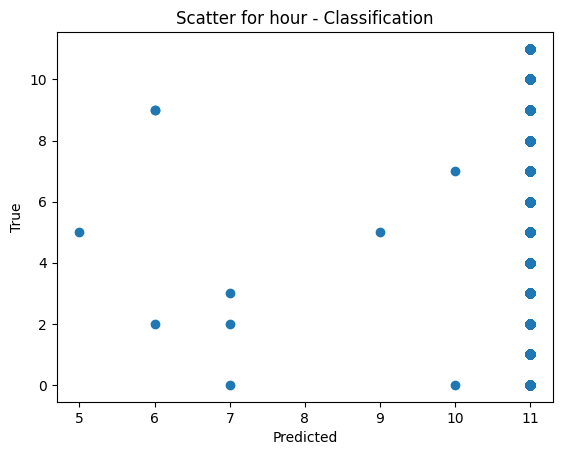

In [ ]:
plt.scatter(y_pred_hours, y_test_hours)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for hour - Classification')

In [ ]:
y_test_minutes =  y_test[:,1]
y_pred_mins = (np.arctan2(y_pred[1][:,1], y_pred[1][:,0]) % (2 * np.pi)) *  60 / (2 * np.pi)


abs_mins = abs(y_pred_mins-y_test[:,1])
cse_min = np.minimum(abs_mins, 60. - abs_mins)

Text(0.5, 1.0, 'Scatter for minutes - Polar')

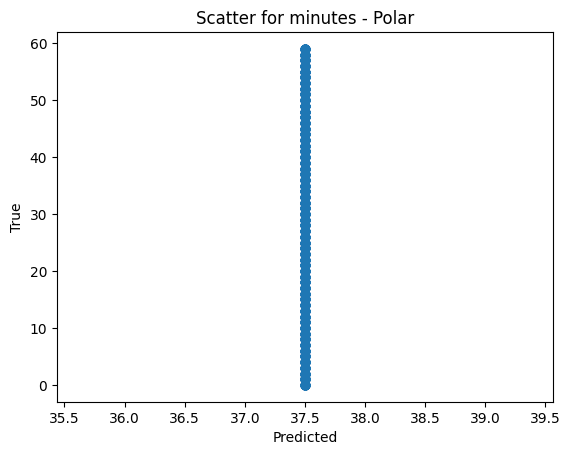

In [ ]:
plt.scatter(y_pred_mins, y_test[:,1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for minutes - Polar')

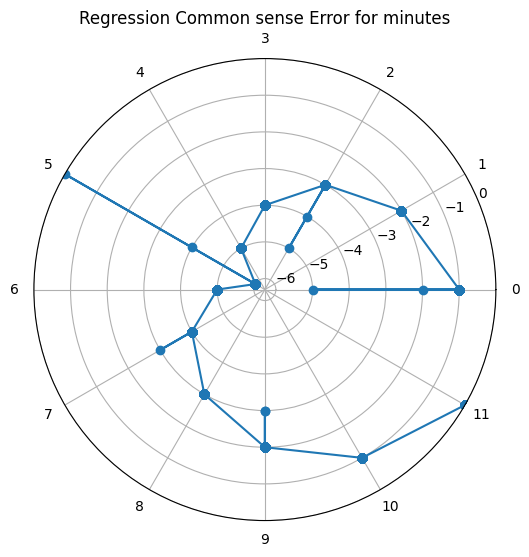

In [ ]:
sorted_indices_hr = np.argsort(y_test_hours)
sorted_y_test_hr = y_test_hours[sorted_indices_hr]

# Create polar plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_hr/12, -cse_hr[sorted_indices_hr], marker='o')

# Add title and show plot
ax.set_title("Regression Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 12, endpoint=False)  # 12 hours around the clock
ax.set_xticks(theta_ticks)

ax.set_xticklabels(range(12))

plt.show()

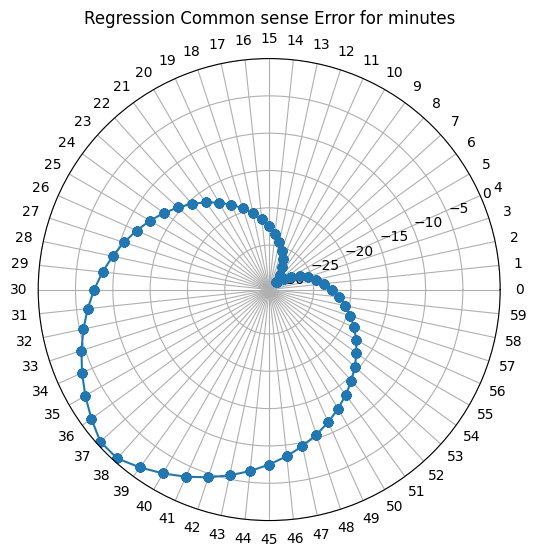

In [ ]:
sorted_indices_min = np.argsort(y_test_minutes)
sorted_y_test_min = y_test_minutes[sorted_indices_min]

# Create polar plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_min/60, -cse_min[sorted_indices_min], marker='o')

# Add title and show plot
ax.set_title("Regression Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 60, endpoint=False)  # 60 mins around the clock
ax.set_xticks(theta_ticks)

ax.set_xticklabels(range(60))

plt.show()

In [ ]:
y_train_pred = model.predict(x_train.reshape(x_train.shape[0], img_rows, img_cols)).flatten()
abs_values = abs(y_train_pred.flatten()-y_train)
common_sense_error = np.minimum(abs_values, 12. - abs_values)
cse_train = np.mean(common_sense_error)

450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


AttributeError: 'list' object has no attribute 'flatten'

In [ ]:
y_val_pred = model.predict(x_val.reshape(x_val.shape[0], img_rows, img_cols)).flatten()
abs_values = abs(y_val_pred.flatten()-y_val)
common_sense_error = np.minimum(abs_values, 12. - abs_values)
cse_val = np.mean(common_sense_error)

: 

In [ ]:
min(history.history['val_loss'])

: 

In [ ]:
min_val_loss_index = history.history['val_loss'].index(min(history.history['val_loss']))
history.history['loss'][min_val_loss_index]

: 

In [ ]:
history.history['mae'][min_val_loss_index]

: 

In [ ]:
history.history['val_mae'][min_val_loss_index]

: 

In [ ]:
print(f"Min Val loss : {min(history.history['val_loss'])}")
print(f"Loss at this : {history.history['loss'][min_val_loss_index]}")
print(f"MAE : {history.history['mae'][min_val_loss_index]}")
print(f"MAE Val : {history.history['val_mae'][min_val_loss_index]}")
print(f"Common Sense MAE Train : {cse_train}")
print(f"Common Sense MAE Val : {cse_val}")
print(f"Common Sense MAE Test : {score}")

: 

In [ ]:
import math
import numpy as np
import keras_tuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from sklearn.model_selection import train_test_split

In [ ]:
images = np.load("A1/data/images.npy")
labels = np.load("A1/data/labels.npy")

num_classes = len(np.unique(labels[:,0]))

In [ ]:
# Define the function to map (hour, minute) tuples to float values upto 
def time_to_polar(row):
    minute_cosine = math.cos(row[1] * 2 * math.pi / 60)
    minute_sine = math.sin(row[1] * 2 * math.pi / 60)
    return [minute_cosine, minute_sine]

img_rows = images.shape[1]
img_cols = images.shape[2]

In [ ]:
images = images.astype('float32')/255.0

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=42) 
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=33) 


y_train_hours = keras.utils.to_categorical(y_train[:,0], num_classes)
y_train_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_train)


y_test_hours = keras.utils.to_categorical(y_test[:,0], num_classes)
y_test_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_test)


y_val_hours = keras.utils.to_categorical(y_val[:,0], num_classes)
y_val_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_val)


print(y_train_hours.shape)
print(y_train_minutes.shape)

(14400, 12)
(14400, 2)


In [ ]:
batch_size = 64
epochs = 500

if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print(x_val.shape)

(1800, 75, 75, 1)


In [ ]:
def build_model(input_shape):
    input_ = keras.layers.Input(shape=x_train.shape[1:])

    # convolutional layers
    c1 = keras.layers.Conv2D(32, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(input_)
    m1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(c1)
    b1 = keras.layers.BatchNormalization()(m1)

    #2nd layers
    c2 = keras.layers.Conv2D(64, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b1)
    d2=  keras.layers.Dropout(0.10)(c2)
    m2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d2)
    b2 = keras.layers.BatchNormalization()(m2)

    #3rd layers
    c3 = keras.layers.Conv2D(128, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b2)
    d3 = keras.layers.Dropout(0.10)(c3)
    m3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d3)
    b3 = keras.layers.BatchNormalization()(m3)

                            
    #4th layers
    c4 = keras.layers.Conv2D(256, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b3)
    d4 = keras.layers.Dropout(0.10)(c4)
    m4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d4)
    b4 = keras.layers.BatchNormalization()(m4)
                            

    #final layer begins
    f = keras.layers.Flatten()(b4)
                           
                           
    #for hours final layers
    dense_hour1 = keras.layers.Dense(128, activation='relu')(f)
    dense_dropout1 = keras.layers.Dropout(0.10)(dense_hour1)
    final_hour = keras.layers.Dense(num_classes, activation='softmax')(dense_dropout1)


    # for minutes final layers
    minute_dense1 = keras.layers.Dense(512, activation='relu')(f)

    minute_dropout1 = keras.layers.Dropout(0.5)(minute_dense1)
    minute_dense2 = keras.layers.Dense(128, activation='relu')(minute_dropout1)
    minute_dropout2 =  keras.layers.Dropout(0.3)(minute_dense2)
        
    minute_dense3 = keras.layers.Dense(64, activation='relu')(minute_dropout2)
    minute_dropout3 =  keras.layers.Dropout(0.1)(minute_dense3)

    final_minute = keras.layers.Dense(2, activation='tanh')(minute_dropout3)
                          
    model = keras.Model(inputs=input_, outputs=[final_hour, final_minute])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3, 
                                                  weight_decay=1e-5), 
                  loss=['categorical_crossentropy', 'huber'], metrics=["accuracy", 'mae'])

    return model

In [ ]:
model = build_model(input_shape=input_shape)
model.summary()

/local/s3777103/IDL-11/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 75, 75, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 75, 75,    │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 37, 37,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 37, 37,    │        128 │ max_pooling2d_4[… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 37, 37,    │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 37, 37,    │          0 │ conv2d_5[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 18, 18,    │          0 │ dropout_7[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 18, 18,    │        256 │ max_pooling2d_5[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 18, 18,    │     73,856 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 18, 18,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 9, 9, 128) │          0 │ dropout_8[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 128) │        512 │ max_pooling2d_6[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 9, 9, 256) │    295,168 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 9, 9, 256) │          0 │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 4, 4, 256) │          0 │ dropout_9[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 256) │      1,024 │ max_pooling2d_7[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 4096)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 512)       │  2,097,664 │ flatten_1[0][0] 

 Total params: 3,087,438 (11.78 MB)

 Trainable params: 3,086,478 (11.77 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Initialize EarlyStopping with patience
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=50,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
)


history = model.fit(x_train, [y_train_hours, y_train_minutes],
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_val, [y_val_hours, y_val_minutes]),
                callbacks=[early_stopping, reduce_lr]
)

Epoch 1/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - dense_11_loss: 0.5767 - dense_11_mae: 0.9505 - dense_7_accuracy: 0.0833 - dense_7_loss: 2.6311 - loss: 3.2079 - val_dense_11_loss: 0.5814 - val_dense_11_mae: 0.9470 - val_dense_7_accuracy: 0.0794 - val_dense_7_loss: 2.4960 - val_loss: 3.0761 - learning_rate: 0.0010
Epoch 2/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - dense_11_loss: 0.6098 - dense_11_mae: 0.9828 - dense_7_accuracy: 0.0936 - dense_7_loss: 2.4624 - loss: 3.0722 - val_dense_11_loss: 0.5153 - val_dense_11_mae: 0.8871 - val_dense_7_accuracy: 0.0917 - val_dense_7_loss: 2.4862 - val_loss: 3.0069 - learning_rate: 0.0010
Epoch 3/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - dense_11_loss: 0.6105 - dense_11_mae: 0.9830 - dense_7_accuracy: 0.1045 - dense_7_loss: 2.4464 - loss: 3.0569 - val_dense_11_loss: 0.6199 - val_dense_11_mae: 0.9877 - val_dense_7_accuracy: 0.1000 - val_dense_7_loss: 4.2271 - val_loss: 4.8222 - learning_rate: 0.0010
Epoch 4/500
225/225 ━━━━━━━━━━━━━━━

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

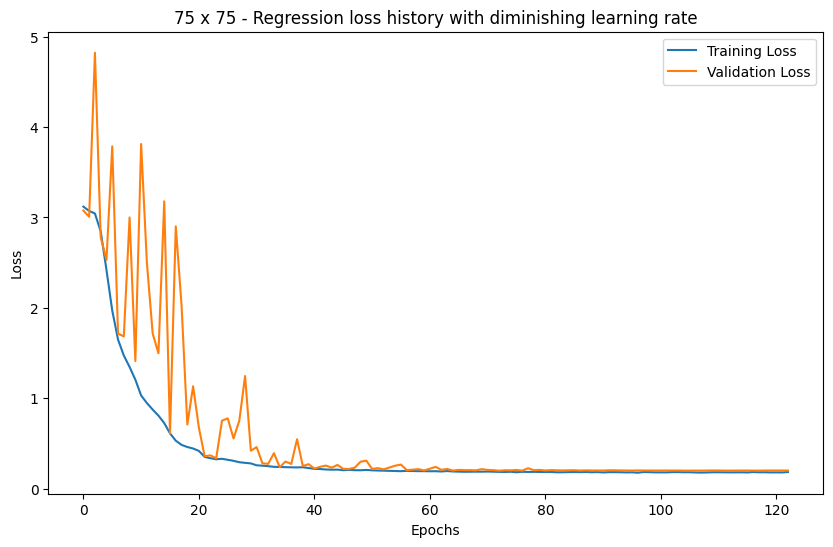

In [ ]:
# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'{img_rows} x {img_cols} - Regression loss history with diminishing learning rate')
plt.legend()
plt.show()
plt.close()

In [ ]:
y_pred = model.predict(x_test)

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


In [ ]:
y_pred_hours = np.argmax(y_pred[0], axis=1)
y_test_hours = y_test[:,0]

abs_hr = np.abs(y_pred_hours - y_test_hours)
cse_hr = np.minimum(abs_hr, 12 - abs_hr)

Text(0.5, 1.0, 'Scatter for hour - Classification')

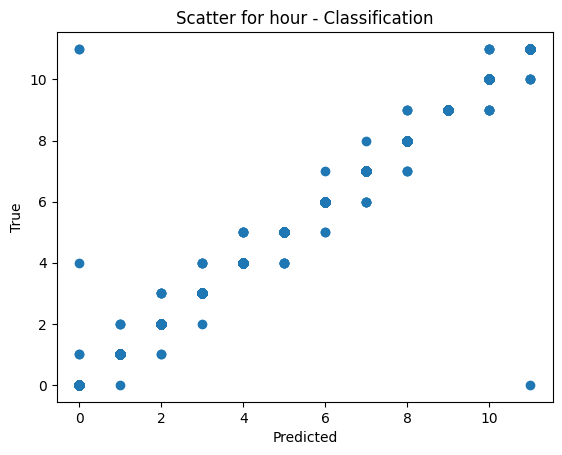

In [ ]:
plt.scatter(y_pred_hours, y_test_hours)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for hour - Classification')

In [ ]:
y_test_minutes =  y_test[:,1]
y_pred_mins = (np.arctan2(y_pred[1][:,1], y_pred[1][:,0]) % (2 * np.pi)) *  60 / (2 * np.pi)


abs_mins = abs(y_pred_mins-y_test[:,1])
cse_min = np.minimum(abs_mins, 60. - abs_mins)

Text(0.5, 1.0, 'Scatter for minutes - Polar')

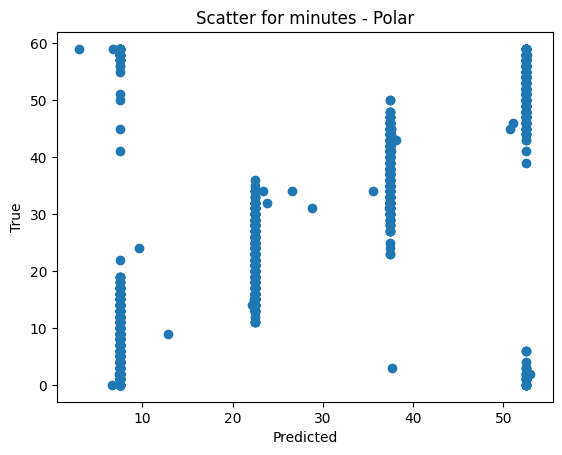

In [ ]:
plt.scatter(y_pred_mins, y_test[:,1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for minutes - Polar')

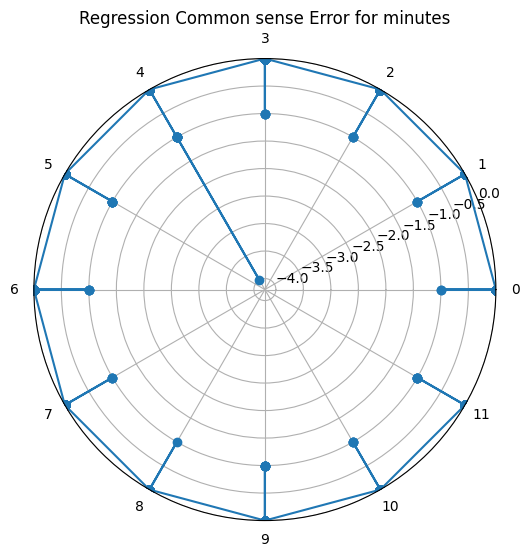

In [ ]:
sorted_indices_hr = np.argsort(y_test_hours)
sorted_y_test_hr = y_test_hours[sorted_indices_hr]

# Create polar plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_hr/12, -cse_hr[sorted_indices_hr], marker='o')

# Add title and show plot
ax.set_title("Regression Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 12, endpoint=False)  # 12 hours around the clock
ax.set_xticks(theta_ticks)

ax.set_xticklabels(range(12))

plt.show()

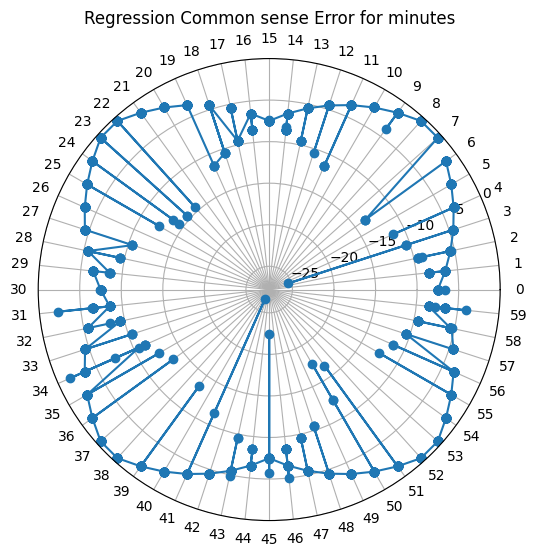

In [ ]:
sorted_indices_min = np.argsort(y_test_minutes)
sorted_y_test_min = y_test_minutes[sorted_indices_min]

# Create polar plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_min/60, -cse_min[sorted_indices_min], marker='o')

# Add title and show plot
ax.set_title("Regression Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 60, endpoint=False)  # 60 mins around the clock
ax.set_xticks(theta_ticks)

ax.set_xticklabels(range(60))

plt.show()

Connected to .venv (Python 3.10.7)

In [ ]:
import math
import numpy as np
import keras_tuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from sklearn.model_selection import train_test_split

2024-11-07 15:01:09.790578: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-07 15:01:09.806938: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 15:01:09.827184: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 15:01:09.833344: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 15:01:09.850354: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
images = np.load("A1/data/images.npy")
labels = np.load("A1/data/labels.npy")

num_classes = len(np.unique(labels[:,0]))

In [ ]:
# Define the function to map (hour, minute) tuples to float values upto 
def time_to_polar(row):
    minute_cosine = math.cos(row[1] * 2 * math.pi / 60)
    minute_sine = math.sin(row[1] * 2 * math.pi / 60)
    return [minute_cosine, minute_sine]

img_rows = images.shape[1]
img_cols = images.shape[2]

In [ ]:
images = images.astype('float32')/255.0

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=42) 
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=33) 

In [ ]:
y_train_hours = keras.utils.to_categorical(y_train[:,0], num_classes)
y_train_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_train)


y_test_hours = keras.utils.to_categorical(y_test[:,0], num_classes)
y_test_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_test)


y_val_hours = keras.utils.to_categorical(y_val[:,0], num_classes)
y_val_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_val)


print(y_train_hours.shape)
print(y_train_minutes.shape)

(14400, 12)
(14400, 2)


In [ ]:
batch_size = 64
epochs = 500

if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print(x_val.shape)

(1800, 75, 75, 1)


In [ ]:
def build_model(input_shape):
    input_ = keras.layers.Input(shape=x_train.shape[1:])

    # convolutional layers
    c1 = keras.layers.Conv2D(32, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(input_)
    m1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(c1)
    b1 = keras.layers.BatchNormalization()(m1)

    #2nd layers
    c2 = keras.layers.Conv2D(64, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b1)
    d2=  keras.layers.Dropout(0.10)(c2)
    m2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d2)
    b2 = keras.layers.BatchNormalization()(m2)

    #3rd layers
    c3 = keras.layers.Conv2D(128, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b2)
    d3 = keras.layers.Dropout(0.10)(c3)
    m3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d3)
    b3 = keras.layers.BatchNormalization()(m3)

                            
    #4th layers
    c4 = keras.layers.Conv2D(256, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b3)
    d4 = keras.layers.Dropout(0.10)(c4)
    m4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d4)
    b4 = keras.layers.BatchNormalization()(m4)
                            

    #final layer begins
    f = keras.layers.Flatten()(b4)
                           
                           
    #for hours final layers
    dense_hour1 = keras.layers.Dense(128, activation='relu')(f)
    dense_dropout1 = keras.layers.Dropout(0.10)(dense_hour1)
    final_hour = keras.layers.Dense(num_classes, activation='softmax')(dense_dropout1)


    # for minutes final layers
    minute_dense1 = keras.layers.Dense(512, activation='relu')(f)

    minute_dropout1 = keras.layers.Dropout(0.5)(minute_dense1)
    minute_dense2 = keras.layers.Dense(128, activation='relu')(minute_dropout1)
    minute_dropout2 =  keras.layers.Dropout(0.3)(minute_dense2)
        
    minute_dense3 = keras.layers.Dense(64, activation='relu')(minute_dropout2)
    minute_dropout3 =  keras.layers.Dropout(0.1)(minute_dense3)

    final_minute = keras.layers.Dense(2, activation='tanh')(minute_dropout3)
                          
    model = keras.Model(inputs=input_, outputs=[final_hour, final_minute])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3, 
                                                  weight_decay=1e-5), 
                  loss=['categorical_crossentropy', 'huber'], metrics=["accuracy", 'mae'])

    return model

In [ ]:
model = build_model(input_shape=input_shape)
model.summary()

/local/s3777103/IDL-11/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-07 15:01:16.185979: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22461 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:3b:00.0, compute capability: 8.6
2024-11-07 15:01:16.187069: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22461 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 75, 75, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 75, 75,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 37, 37,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 37, 37,    │        128 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 37, 37,    │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 37, 37,    │          0 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 18, 18,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 18, 18,    │        256 │ max_pooling2d_1[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 18, 18,    │     73,856 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 18, 18,    │          0 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 9, 9, 128) │          0 │ dropout_1[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 128) │        512 │ max_pooling2d_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 9, 9, 256) │    295,168 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 9, 9, 256) │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 4, 4, 256) │          0 │ dropout_2[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 256) │      1,024 │ max_pooling2d_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4096)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │  2,097,664 │ flatten[0][0]   

 Total params: 3,087,438 (11.78 MB)

 Trainable params: 3,086,478 (11.77 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Initialize EarlyStopping with patience
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=50,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
)


history = model.fit(x_train, [y_train_hours, y_train_minutes],
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_val, [y_val_hours, y_val_minutes]),
                callbacks=[early_stopping, reduce_lr]
)

Epoch 1/500


I0000 00:00:1731009681.740470   10562 service.cc:146] XLA service 0x7fa604001070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731009681.740535   10562 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
I0000 00:00:1731009681.740544   10562 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-11-07 15:01:21.858894: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-07 15:01:22.336674: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-11-07 15:01:24.260134: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 4 bytes spill stores, 4 bytes spill loads

2024-11-07 15:01:26.717445: I externa

 20/225 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - dense_1_accuracy: 0.0752 - dense_1_loss: 3.7294 - dense_5_loss: 0.4904 - dense_5_mae: 0.8595 - loss: 4.2198

I0000 00:00:1731009695.120338   10562 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


223/225 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - dense_1_accuracy: 0.0799 - dense_1_loss: 2.7355 - dense_5_loss: 0.5259 - dense_5_mae: 0.8955 - loss: 3.2614

2024-11-07 15:01:44.325352: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_341', 8 bytes spill stores, 8 bytes spill loads



225/225 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - dense_1_accuracy: 0.0799 - dense_1_loss: 2.7330 - dense_5_loss: 0.5254 - dense_5_mae: 0.8950 - loss: 3.2584 - val_dense_1_accuracy: 0.0811 - val_dense_1_loss: 2.5537 - val_dense_5_loss: 0.2744 - val_dense_5_mae: 0.6593 - val_loss: 2.8224 - learning_rate: 0.0010
Epoch 2/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - dense_1_accuracy: 0.0991 - dense_1_loss: 2.4598 - dense_5_loss: 0.2752 - dense_5_mae: 0.6436 - loss: 2.7350 - val_dense_1_accuracy: 0.0778 - val_dense_1_loss: 2.5108 - val_dense_5_loss: 0.2576 - val_dense_5_mae: 0.6437 - val_loss: 2.7668 - learning_rate: 0.0010
Epoch 3/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - dense_1_accuracy: 0.1435 - dense_1_loss: 2.3127 - dense_5_loss: 0.2231 - dense_5_mae: 0.5767 - loss: 2.5357 - val_dense_1_accuracy: 0.0917 - val_dense_1_loss: 2.4682 - val_dense_5_loss: 0.2526 - val_dense_5_mae: 0.6327 - val_loss: 2.7167 - learning_rate: 0.0010
Epoch 4/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - dens

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'{img_rows} x {img_cols} - Regression loss history with diminishing learning rate')
plt.legend()
plt.show()
plt.close()

In [ ]:
y_pred = model.predict(x_test)

2024-11-07 15:05:29.717263: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 16 bytes spill stores, 16 bytes spill loads



57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step


In [ ]:
y_pred_hours = np.argmax(y_pred[0], axis=1)
y_test_hours = y_test[:,0]

abs_hr = np.abs(y_pred_hours - y_test_hours)
cse_hr = np.minimum(abs_hr, 12 - abs_hr)

Text(0.5, 1.0, 'Scatter for hour - Classification')

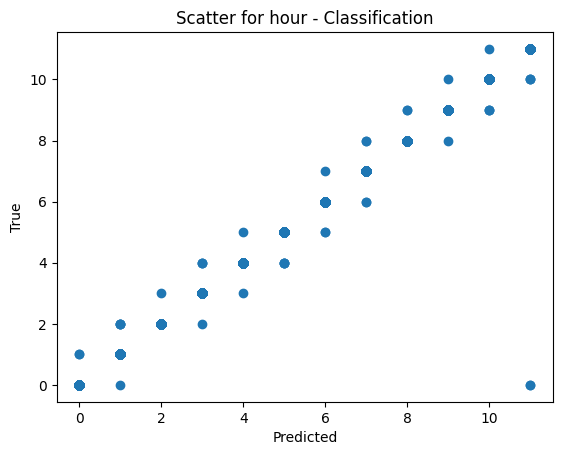

In [ ]:
plt.scatter(y_pred_hours, y_test_hours)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for hour - Classification')

In [ ]:
y_test_minutes =  y_test[:,1]
y_pred_mins = (np.arctan2(y_pred[1][:,1], y_pred[1][:,0]) % (2 * np.pi)) *  60 / (2 * np.pi)


abs_mins = abs(y_pred_mins-y_test[:,1])
cse_min = np.minimum(abs_mins, 60. - abs_mins)

Text(0.5, 1.0, 'Scatter for minutes - Polar')

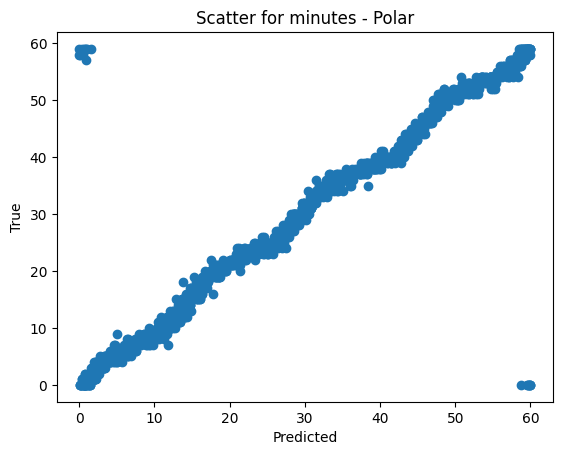

In [ ]:
plt.scatter(y_pred_mins, y_test[:,1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for minutes - Polar')

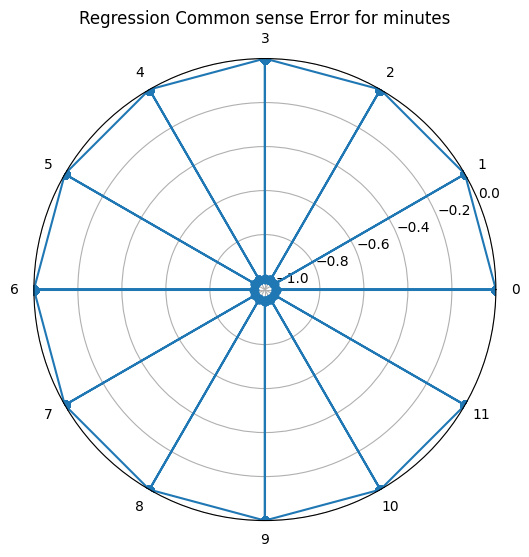

In [ ]:
sorted_indices_hr = np.argsort(y_test_hours)
sorted_y_test_hr = y_test_hours[sorted_indices_hr]

# Create polar plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_hr/12, -cse_hr[sorted_indices_hr], marker='o')

# Add title and show plot
ax.set_title("Regression Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 12, endpoint=False)  # 12 hours around the clock
ax.set_xticks(theta_ticks)

ax.set_xticklabels(range(12))

plt.show()

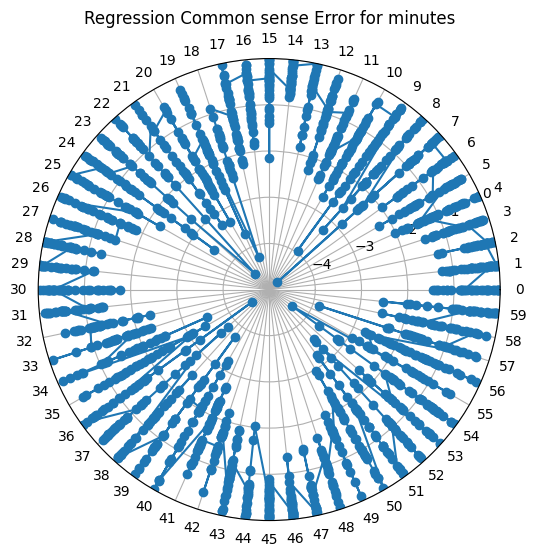

In [ ]:
sorted_indices_min = np.argsort(y_test_minutes)
sorted_y_test_min = y_test_minutes[sorted_indices_min]

# Create polar plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_min/60, -cse_min[sorted_indices_min], marker='o')

# Add title and show plot
ax.set_title("Regression Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 60, endpoint=False)  # 60 mins around the clock
ax.set_xticks(theta_ticks)

ax.set_xticklabels(range(60))

plt.show()

In [ ]:
# y_train_pred = model.predict(x_train.reshape(x_train.shape[0], img_rows, img_cols)).flatten()
# abs_values = abs(y_train_pred.flatten()-y_train)
# common_sense_error = np.minimum(abs_values, 12. - abs_values)
# cse_train = np.mean(common_sense_error)

# #%%
# y_val_pred = model.predict(x_val.reshape(x_val.shape[0], img_rows, img_cols)).flatten()
# abs_values = abs(y_val_pred.flatten()-y_val)
# common_sense_error = np.minimum(abs_values, 12. - abs_values)
# cse_val = np.mean(common_sense_error)

# #%%

# min(history.history['val_loss'])

# #%%
# min_val_loss_index = history.history['val_loss'].index(min(history.history['val_loss']))
# history.history['loss'][min_val_loss_index]
# # %%
# history.history['mae'][min_val_loss_index]

# #%%
# history.history['val_mae'][min_val_loss_index]

# #%%
# print(f"Min Val loss : {min(history.history['val_loss'])}")
# print(f"Loss at this : {history.history['loss'][min_val_loss_index]}")
# print(f"MAE : {history.history['mae'][min_val_loss_index]}")
# print(f"MAE Val : {history.history['val_mae'][min_val_loss_index]}")
# print(f"Common Sense MAE Train : {cse_train}")
# print(f"Common Sense MAE Val : {cse_val}")
# print(f"Common Sense MAE Test : {score}")

In [ ]:
import math
import numpy as np
import keras_tuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from sklearn.model_selection import train_test_split

In [ ]:
images = np.load("A1/data/images.npy")
labels = np.load("A1/data/labels.npy")

num_classes = len(np.unique(labels[:,0]))

In [ ]:
# Define the function to map (hour, minute) tuples to float values upto 
def time_to_polar(row):
    minute_cosine = math.cos(row[1] * 2 * math.pi / 60)
    minute_sine = math.sin(row[1] * 2 * math.pi / 60)
    return [minute_cosine, minute_sine]

img_rows = images.shape[1]
img_cols = images.shape[2]

In [ ]:
images = images.astype('float32')/255.0

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=42) 
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=33) 

In [ ]:
y_train_hours = keras.utils.to_categorical(y_train[:,0], num_classes)
y_train_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_train)


y_test_hours = keras.utils.to_categorical(y_test[:,0], num_classes)
y_test_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_test)


y_val_hours = keras.utils.to_categorical(y_val[:,0], num_classes)
y_val_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_val)


print(y_train_hours.shape)
print(y_train_minutes.shape)

(14400, 12)
(14400, 2)


In [ ]:
batch_size = 64
epochs = 500

if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print(x_val.shape)

(1800, 75, 75, 1)


In [ ]:
def build_model(input_shape):
    input_ = keras.layers.Input(shape=x_train.shape[1:])

    # convolutional layers
    c1 = keras.layers.Conv2D(32, kernel_size=(7, 7),
                        activation='relu',padding='same',
                        input_shape=input_shape)(input_)
    m1 = keras.layers.MaxPooling2D(pool_size=(3, 3))(c1)
    b1 = keras.layers.BatchNormalization()(m1)

    #2nd layers
    c2 = keras.layers.Conv2D(64, kernel_size=(5, 5),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b1)
    d2=  keras.layers.Dropout(0.10)(c2)
    m2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d2)
    b2 = keras.layers.BatchNormalization()(m2)

    #3rd layers
    c3 = keras.layers.Conv2D(128, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b2)
    d3 = keras.layers.Dropout(0.10)(c3)
    m3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d3)
    b3 = keras.layers.BatchNormalization()(m3)

                            
    #4th layers
    c4 = keras.layers.Conv2D(256, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b3)
    d4 = keras.layers.Dropout(0.10)(c4)
    m4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d4)
    b4 = keras.layers.BatchNormalization()(m4)
                            

    #final layer begins
    f = keras.layers.Flatten()(b4)
                           
                           
    #for hours final layers
    dense_hour1 = keras.layers.Dense(128, activation='relu')(f)
    dense_dropout1 = keras.layers.Dropout(0.10)(dense_hour1)
    final_hour = keras.layers.Dense(num_classes, activation='softmax')(dense_dropout1)


    # for minutes final layers
    minute_dense1 = keras.layers.Dense(512, activation='relu')(f)

    minute_dropout1 = keras.layers.Dropout(0.5)(minute_dense1)
    minute_dense2 = keras.layers.Dense(128, activation='relu')(minute_dropout1)
    minute_dropout2 =  keras.layers.Dropout(0.3)(minute_dense2)
        
    minute_dense3 = keras.layers.Dense(64, activation='relu')(minute_dropout2)
    minute_dropout3 =  keras.layers.Dropout(0.1)(minute_dense3)

    final_minute = keras.layers.Dense(2, activation='tanh')(minute_dropout3)
                          
    model = keras.Model(inputs=input_, outputs=[final_hour, final_minute])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3, 
                                                  weight_decay=1e-5), 
                  loss=['categorical_crossentropy', 'huber'], metrics=["accuracy", 'mae'])

    return model

In [ ]:
model = build_model(input_shape=input_shape)
model.summary()

/local/s3777103/IDL-11/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 75, 75, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 75, 75,    │      1,600 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 25, 25,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 25,    │        128 │ max_pooling2d_4[… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 25, 25,    │     51,264 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 25, 25,    │          0 │ conv2d_5[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 12, 12,    │          0 │ dropout_7[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        256 │ max_pooling2d_5[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 12, 12,    │     73,856 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 12, 12,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 6, 6, 128) │          0 │ dropout_8[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 6, 128) │        512 │ max_pooling2d_6[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 6, 6, 256) │    295,168 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 6, 6, 256) │          0 │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 3, 3, 256) │          0 │ dropout_9[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 3, 256) │      1,024 │ max_pooling2d_7[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 2304)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 512)       │  1,180,160 │ flatten_1[0][0] 

 Total params: 1,974,606 (7.53 MB)

 Trainable params: 1,973,646 (7.53 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Initialize EarlyStopping with patience
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=50,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
)


history = model.fit(x_train, [y_train_hours, y_train_minutes],
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_val, [y_val_hours, y_val_minutes]),
                callbacks=[early_stopping, reduce_lr]
)

Epoch 1/500


2024-11-07 15:10:04.854326: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 4 bytes spill stores, 4 bytes spill loads

2024-11-07 15:10:07.068646: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 168 bytes spill stores, 168 bytes spill loads

2024-11-07 15:10:07.157437: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 108 bytes spill stores, 108 bytes spill loads

2024-11-07 15:10:07.267327: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 108 bytes spill stores, 108 bytes spill loads



225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - dense_11_loss: 0.3573 - dense_11_mae: 0.7274 - dense_7_accuracy: 0.0827 - dense_7_loss: 2.6239 - loss: 2.9812 - val_dense_11_loss: 0.2536 - val_dense_11_mae: 0.6384 - val_dense_7_accuracy: 0.0828 - val_dense_7_loss: 2.5487 - val_loss: 2.7995 - learning_rate: 0.0010
Epoch 2/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - dense_11_loss: 0.2406 - dense_11_mae: 0.6176 - dense_7_accuracy: 0.0850 - dense_7_loss: 2.4847 - loss: 2.7254 - val_dense_11_loss: 0.2514 - val_dense_11_mae: 0.6381 - val_dense_7_accuracy: 0.0833 - val_dense_7_loss: 2.5018 - val_loss: 2.7533 - learning_rate: 0.0010
Epoch 3/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - dense_11_loss: 0.2250 - dense_11_mae: 0.5820 - dense_7_accuracy: 0.1177 - dense_7_loss: 2.4018 - loss: 2.6268 - val_dense_11_loss: 0.2525 - val_dense_11_mae: 0.6060 - val_dense_7_accuracy: 0.1000 - val_dense_7_loss: 3.4170 - val_loss: 3.6797 - learning_rate: 0.0010
Epoch 4/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

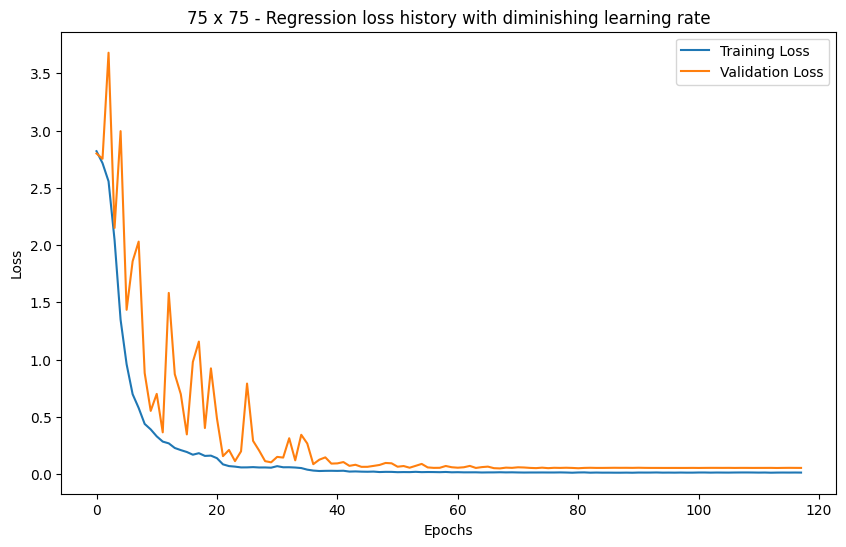

In [ ]:
# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'{img_rows} x {img_cols} - Regression loss history with diminishing learning rate')
plt.legend()
plt.show()
plt.close()

In [ ]:
y_pred = model.predict(x_test)

2024-11-07 15:13:55.630243: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 168 bytes spill stores, 168 bytes spill loads



57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step


In [ ]:
y_pred_hours = np.argmax(y_pred[0], axis=1)
y_test_hours = y_test[:,0]

abs_hr = np.abs(y_pred_hours - y_test_hours)
cse_hr = np.minimum(abs_hr, 12 - abs_hr)

Text(0.5, 1.0, 'Scatter for hour - Classification')

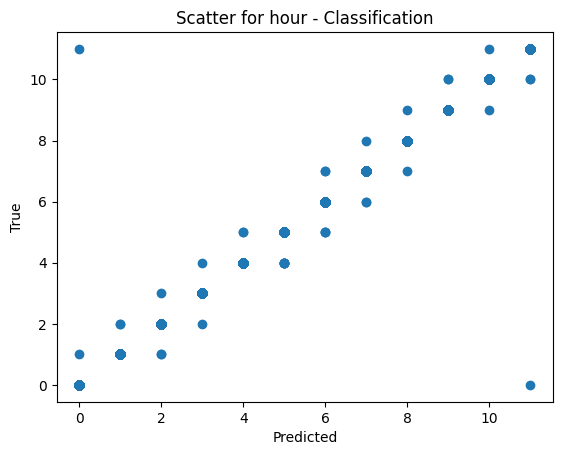

In [ ]:
plt.scatter(y_pred_hours, y_test_hours)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for hour - Classification')

In [ ]:
y_test_minutes =  y_test[:,1]
y_pred_mins = (np.arctan2(y_pred[1][:,1], y_pred[1][:,0]) % (2 * np.pi)) *  60 / (2 * np.pi)


abs_mins = abs(y_pred_mins-y_test[:,1])
cse_min = np.minimum(abs_mins, 60. - abs_mins)

Text(0.5, 1.0, 'Scatter for minutes - Polar')

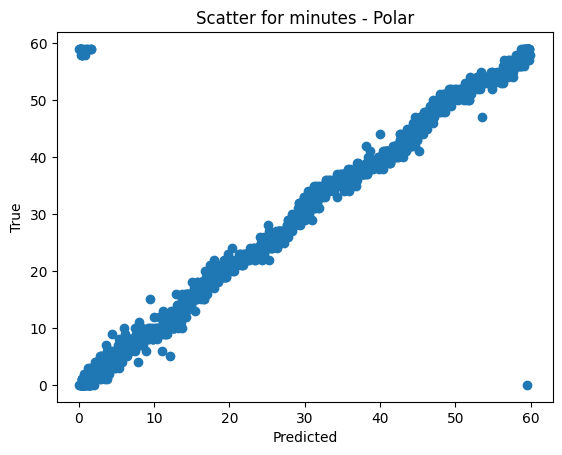

In [ ]:
plt.scatter(y_pred_mins, y_test[:,1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for minutes - Polar')

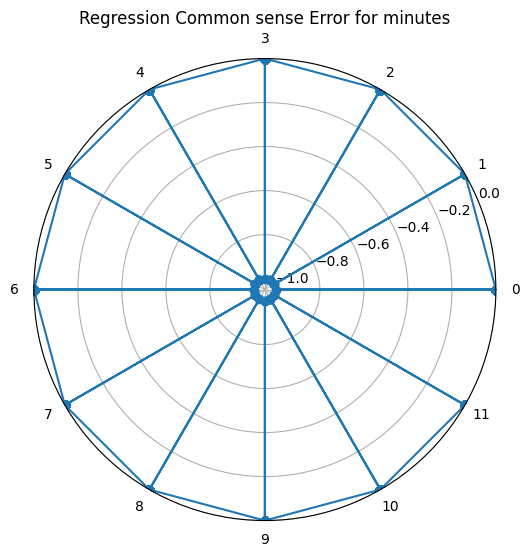

In [ ]:
sorted_indices_hr = np.argsort(y_test_hours)
sorted_y_test_hr = y_test_hours[sorted_indices_hr]

# Create polar plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_hr/12, -cse_hr[sorted_indices_hr], marker='o')

# Add title and show plot
ax.set_title("Regression Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 12, endpoint=False)  # 12 hours around the clock
ax.set_xticks(theta_ticks)

ax.set_xticklabels(range(12))

plt.show()

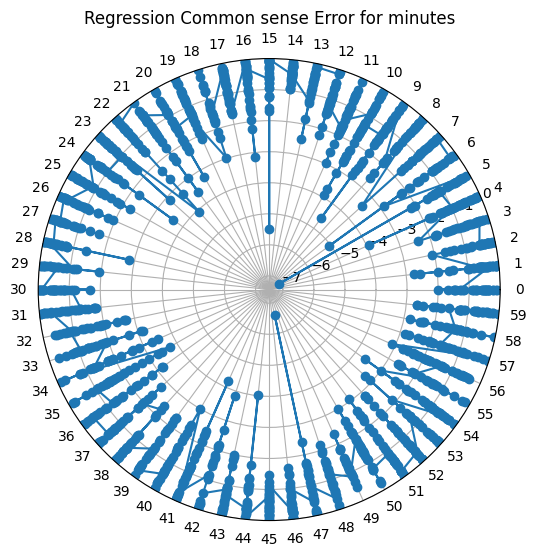

In [ ]:
sorted_indices_min = np.argsort(y_test_minutes)
sorted_y_test_min = y_test_minutes[sorted_indices_min]

# Create polar plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_min/60, -cse_min[sorted_indices_min], marker='o')

# Add title and show plot
ax.set_title("Regression Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 60, endpoint=False)  # 60 mins around the clock
ax.set_xticks(theta_ticks)

ax.set_xticklabels(range(60))

plt.show()

In [ ]:
# y_train_pred = model.predict(x_train.reshape(x_train.shape[0], img_rows, img_cols)).flatten()
# abs_values = abs(y_train_pred.flatten()-y_train)
# common_sense_error = np.minimum(abs_values, 12. - abs_values)
# cse_train = np.mean(common_sense_error)

# #%%
# y_val_pred = model.predict(x_val.reshape(x_val.shape[0], img_rows, img_cols)).flatten()
# abs_values = abs(y_val_pred.flatten()-y_val)
# common_sense_error = np.minimum(abs_values, 12. - abs_values)
# cse_val = np.mean(common_sense_error)

# #%%

# min(history.history['val_loss'])

# #%%
# min_val_loss_index = history.history['val_loss'].index(min(history.history['val_loss']))
# history.history['loss'][min_val_loss_index]
# # %%
# history.history['mae'][min_val_loss_index]

# #%%
# history.history['val_mae'][min_val_loss_index]

# #%%
# print(f"Min Val loss : {min(history.history['val_loss'])}")
# print(f"Loss at this : {history.history['loss'][min_val_loss_index]}")
# print(f"MAE : {history.history['mae'][min_val_loss_index]}")
# print(f"MAE Val : {history.history['val_mae'][min_val_loss_index]}")
# print(f"Common Sense MAE Train : {cse_train}")
# print(f"Common Sense MAE Val : {cse_val}")
# print(f"Common Sense MAE Test : {score}")

In [ ]:
import math
import numpy as np
import keras_tuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from sklearn.model_selection import train_test_split

In [ ]:
images = np.load("A1/data/images_150.npy")
labels = np.load("A1/data/labels_150.npy")

num_classes = len(np.unique(labels[:,0]))

In [ ]:
# Define the function to map (hour, minute) tuples to float values upto 
def time_to_polar(row):
    minute_cosine = math.cos(row[1] * 2 * math.pi / 60)
    minute_sine = math.sin(row[1] * 2 * math.pi / 60)
    return [minute_cosine, minute_sine]

img_rows = images.shape[1]
img_cols = images.shape[2]

In [ ]:
images = images.astype('float32')/255.0

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=42) 
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=33) 

In [ ]:
y_train_hours = keras.utils.to_categorical(y_train[:,0], num_classes)
y_train_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_train)


y_test_hours = keras.utils.to_categorical(y_test[:,0], num_classes)
y_test_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_test)


y_val_hours = keras.utils.to_categorical(y_val[:,0], num_classes)
y_val_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_val)


print(y_train_hours.shape)
print(y_train_minutes.shape)

(14400, 12)
(14400, 2)


In [ ]:
batch_size = 64
epochs = 500

if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print(x_val.shape)

(1800, 150, 150, 1)


In [ ]:
def build_model(input_shape):
    input_ = keras.layers.Input(shape=x_train.shape[1:])

    # convolutional layers
    c1 = keras.layers.Conv2D(32, kernel_size=(7, 7),
                        activation='relu',padding='same',
                        input_shape=input_shape)(input_)
    m1 = keras.layers.MaxPooling2D(pool_size=(3, 3))(c1)
    b1 = keras.layers.BatchNormalization()(m1)

    #2nd layers
    c2 = keras.layers.Conv2D(64, kernel_size=(5, 5),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b1)
    d2=  keras.layers.Dropout(0.10)(c2)
    m2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d2)
    b2 = keras.layers.BatchNormalization()(m2)

    #3rd layers
    c3 = keras.layers.Conv2D(128, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b2)
    d3 = keras.layers.Dropout(0.10)(c3)
    m3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d3)
    b3 = keras.layers.BatchNormalization()(m3)

                            
    #4th layers
    c4 = keras.layers.Conv2D(256, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b3)
    d4 = keras.layers.Dropout(0.10)(c4)
    m4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d4)
    b4 = keras.layers.BatchNormalization()(m4)
                            

    #final layer begins
    f = keras.layers.Flatten()(b4)
                           
                           
    #for hours final layers
    dense_hour1 = keras.layers.Dense(128, activation='relu')(f)
    dense_dropout1 = keras.layers.Dropout(0.10)(dense_hour1)
    final_hour = keras.layers.Dense(num_classes, activation='softmax')(dense_dropout1)


    # for minutes final layers
    minute_dense1 = keras.layers.Dense(512, activation='relu')(f)

    minute_dropout1 = keras.layers.Dropout(0.5)(minute_dense1)
    minute_dense2 = keras.layers.Dense(128, activation='relu')(minute_dropout1)
    minute_dropout2 =  keras.layers.Dropout(0.3)(minute_dense2)
        
    minute_dense3 = keras.layers.Dense(64, activation='relu')(minute_dropout2)
    minute_dropout3 =  keras.layers.Dropout(0.1)(minute_dense3)

    final_minute = keras.layers.Dense(2, activation='tanh')(minute_dropout3)
                          
    model = keras.Model(inputs=input_, outputs=[final_hour, final_minute])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3, 
                                                  weight_decay=1e-5), 
                  loss=['categorical_crossentropy', 'huber'], metrics=["accuracy", 'mae'])

    return model

In [ ]:
model = build_model(input_shape=input_shape)
model.summary()

/local/s3777103/IDL-11/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 150, 150,  │      1,600 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 50, 50,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        128 │ max_pooling2d_8[… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 50, 50,    │     51,264 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 50, 50,    │          0 │ conv2d_9[0][0]    │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 25, 25,    │          0 │ dropout_14[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 25,    │        256 │ max_pooling2d_9[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 25, 25,    │     73,856 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 25, 25,    │          0 │ conv2d_10[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 12, 12,    │          0 │ dropout_15[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        512 │ max_pooling2d_10… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 12, 12,    │    295,168 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 12, 12,    │          0 │ conv2d_11[0][0]   │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 6, 6, 256) │          0 │ dropout_16[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 6, 256) │      1,024 │ max_pooling2d_11… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 9216)      │          0 │ batch_normalizat

 Total params: 6,398,286 (24.41 MB)

 Trainable params: 6,397,326 (24.40 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Initialize EarlyStopping with patience
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=50,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
)


history = model.fit(x_train, [y_train_hours, y_train_minutes],
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_val, [y_val_hours, y_val_minutes]),
                callbacks=[early_stopping, reduce_lr]
)

Epoch 1/500


2024-11-07 15:15:44.425317: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 4 bytes spill stores, 4 bytes spill loads

2024-11-07 15:15:46.878236: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 108 bytes spill stores, 108 bytes spill loads

2024-11-07 15:15:47.068670: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 108 bytes spill stores, 108 bytes spill loads

2024-11-07 15:15:47.130868: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 16 bytes spill stores, 16 bytes spill loads



225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - dense_13_accuracy: 0.0838 - dense_13_loss: 2.7672 - dense_17_loss: 0.5996 - dense_17_mae: 0.9732 - loss: 3.3668 - val_dense_13_accuracy: 0.0906 - val_dense_13_loss: 2.4867 - val_dense_17_loss: 0.6278 - val_dense_17_mae: 1.0029 - val_loss: 3.1164 - learning_rate: 0.0010
Epoch 2/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - dense_13_accuracy: 0.0866 - dense_13_loss: 2.4849 - dense_17_loss: 0.6266 - dense_17_mae: 1.0023 - loss: 3.1115 - val_dense_13_accuracy: 0.0817 - val_dense_13_loss: 2.4850 - val_dense_17_loss: 0.6278 - val_dense_17_mae: 1.0029 - val_loss: 3.1131 - learning_rate: 0.0010
Epoch 3/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - dense_13_accuracy: 0.0845 - dense_13_loss: 2.4849 - dense_17_loss: 0.6199 - dense_17_mae: 0.9939 - loss: 3.1049 - val_dense_13_accuracy: 0.0833 - val_dense_13_loss: 2.4851 - val_dense_17_loss: 0.6278 - val_dense_17_mae: 1.0029 - val_loss: 3.1132 - learning_rate: 0.0010
Epoch 4/500
225/225 ━━━━━━━━━━━━━

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

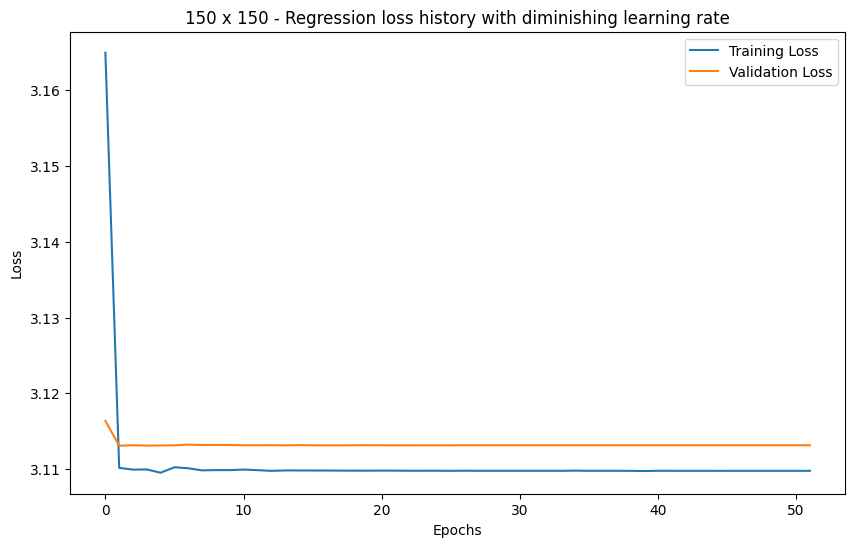

In [ ]:
# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'{img_rows} x {img_cols} - Regression loss history with diminishing learning rate')
plt.legend()
plt.show()
plt.close()

In [ ]:
y_pred = model.predict(x_test)

2024-11-07 15:19:18.930321: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 16 bytes spill stores, 16 bytes spill loads



57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step


In [ ]:
y_pred_hours = np.argmax(y_pred[0], axis=1)
y_test_hours = y_test[:,0]

abs_hr = np.abs(y_pred_hours - y_test_hours)
cse_hr = np.minimum(abs_hr, 12 - abs_hr)

Text(0.5, 1.0, 'Scatter for hour - Classification')

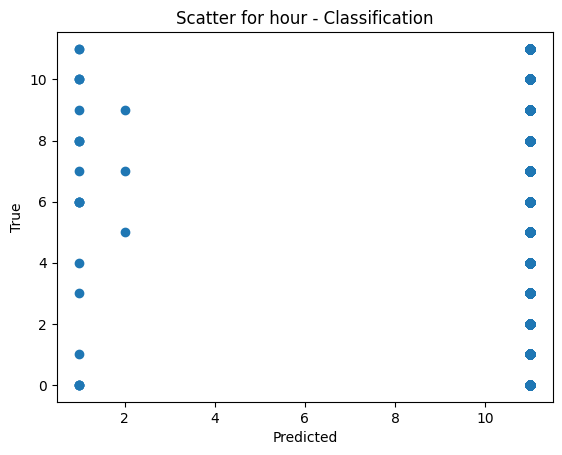

In [ ]:
plt.scatter(y_pred_hours, y_test_hours)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for hour - Classification')

In [ ]:
y_test_minutes =  y_test[:,1]
y_pred_mins = (np.arctan2(y_pred[1][:,1], y_pred[1][:,0]) % (2 * np.pi)) *  60 / (2 * np.pi)


abs_mins = abs(y_pred_mins-y_test[:,1])
cse_min = np.minimum(abs_mins, 60. - abs_mins)

Text(0.5, 1.0, 'Scatter for minutes - Polar')

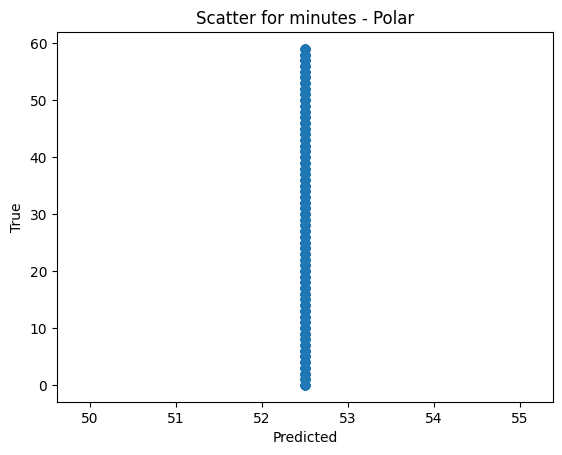

In [ ]:
plt.scatter(y_pred_mins, y_test[:,1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for minutes - Polar')

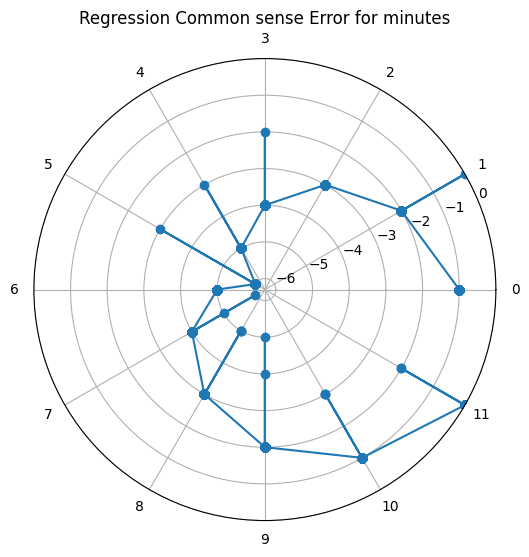

In [ ]:
sorted_indices_hr = np.argsort(y_test_hours)
sorted_y_test_hr = y_test_hours[sorted_indices_hr]

# Create polar plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_hr/12, -cse_hr[sorted_indices_hr], marker='o')

# Add title and show plot
ax.set_title("Regression Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 12, endpoint=False)  # 12 hours around the clock
ax.set_xticks(theta_ticks)

ax.set_xticklabels(range(12))

plt.show()

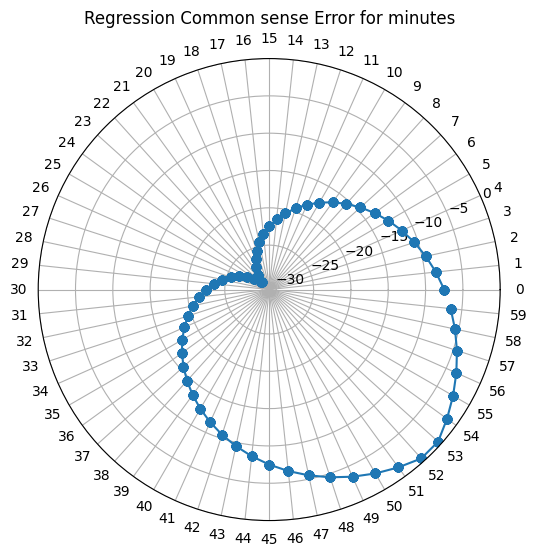

In [ ]:
sorted_indices_min = np.argsort(y_test_minutes)
sorted_y_test_min = y_test_minutes[sorted_indices_min]

# Create polar plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_min/60, -cse_min[sorted_indices_min], marker='o')

# Add title and show plot
ax.set_title("Regression Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 60, endpoint=False)  # 60 mins around the clock
ax.set_xticks(theta_ticks)

ax.set_xticklabels(range(60))

plt.show()

In [ ]:
# y_train_pred = model.predict(x_train.reshape(x_train.shape[0], img_rows, img_cols)).flatten()
# abs_values = abs(y_train_pred.flatten()-y_train)
# common_sense_error = np.minimum(abs_values, 12. - abs_values)
# cse_train = np.mean(common_sense_error)

# #%%
# y_val_pred = model.predict(x_val.reshape(x_val.shape[0], img_rows, img_cols)).flatten()
# abs_values = abs(y_val_pred.flatten()-y_val)
# common_sense_error = np.minimum(abs_values, 12. - abs_values)
# cse_val = np.mean(common_sense_error)

# #%%

# min(history.history['val_loss'])

# #%%
# min_val_loss_index = history.history['val_loss'].index(min(history.history['val_loss']))
# history.history['loss'][min_val_loss_index]
# # %%
# history.history['mae'][min_val_loss_index]

# #%%
# history.history['val_mae'][min_val_loss_index]

# #%%
# print(f"Min Val loss : {min(history.history['val_loss'])}")
# print(f"Loss at this : {history.history['loss'][min_val_loss_index]}")
# print(f"MAE : {history.history['mae'][min_val_loss_index]}")
# print(f"MAE Val : {history.history['val_mae'][min_val_loss_index]}")
# print(f"Common Sense MAE Train : {cse_train}")
# print(f"Common Sense MAE Val : {cse_val}")
# print(f"Common Sense MAE Test : {score}")

In [ ]:
import math
import numpy as np
import keras_tuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from sklearn.model_selection import train_test_split

In [ ]:
images = np.load("A1/data/images_150.npy")
labels = np.load("A1/data/labels_150.npy")

num_classes = len(np.unique(labels[:,0]))

In [ ]:
# Define the function to map (hour, minute) tuples to float values upto 
def time_to_polar(row):
    minute_cosine = math.cos(row[1] * 2 * math.pi / 60)
    minute_sine = math.sin(row[1] * 2 * math.pi / 60)
    return [minute_cosine, minute_sine]

img_rows = images.shape[1]
img_cols = images.shape[2]

In [ ]:
images = images.astype('float32')/255.0

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=42) 
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=33) 

In [ ]:
y_train_hours = keras.utils.to_categorical(y_train[:,0], num_classes)
y_train_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_train)


y_test_hours = keras.utils.to_categorical(y_test[:,0], num_classes)
y_test_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_test)


y_val_hours = keras.utils.to_categorical(y_val[:,0], num_classes)
y_val_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_val)


print(y_train_hours.shape)
print(y_train_minutes.shape)

(14400, 12)
(14400, 2)


In [ ]:
batch_size = 64
epochs = 500

if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print(x_val.shape)

(1800, 150, 150, 1)


In [ ]:
def build_model(input_shape):
    input_ = keras.layers.Input(shape=x_train.shape[1:])

    # convolutional layers
    c1 = keras.layers.Conv2D(64, kernel_size=(7, 7),
                        activation='relu',padding='same',
                        input_shape=input_shape)(input_)
    m1 = keras.layers.MaxPooling2D(pool_size=(3, 3))(c1)
    b1 = keras.layers.BatchNormalization()(m1)

    #2nd layers
    c2 = keras.layers.Conv2D(128, kernel_size=(5, 5),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b1)
    d2=  keras.layers.Dropout(0.10)(c2)
    m2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d2)
    b2 = keras.layers.BatchNormalization()(m2)

    #3rd layers
    c3 = keras.layers.Conv2D(256, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b2)
    d3 = keras.layers.Dropout(0.10)(c3)
    m3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d3)
    b3 = keras.layers.BatchNormalization()(m3)

                            
    #4th layers
    c4 = keras.layers.Conv2D(512, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b3)
    d4 = keras.layers.Dropout(0.10)(c4)
    m4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d4)
    b4 = keras.layers.BatchNormalization()(m4)
                            

    #final layer begins
    f = keras.layers.Flatten()(b4)
                           
                           
    #for hours final layers
    dense_hour1 = keras.layers.Dense(128, activation='relu')(f)
    dense_dropout1 = keras.layers.Dropout(0.10)(dense_hour1)
    final_hour = keras.layers.Dense(num_classes, activation='softmax')(dense_dropout1)


    # for minutes final layers
    minute_dense1 = keras.layers.Dense(512, activation='relu')(f)

    minute_dropout1 = keras.layers.Dropout(0.5)(minute_dense1)
    minute_dense2 = keras.layers.Dense(128, activation='relu')(minute_dropout1)
    minute_dropout2 =  keras.layers.Dropout(0.3)(minute_dense2)
        
    minute_dense3 = keras.layers.Dense(64, activation='relu')(minute_dropout2)
    minute_dropout3 =  keras.layers.Dropout(0.1)(minute_dense3)

    final_minute = keras.layers.Dense(2, activation='tanh')(minute_dropout3)
                          
    model = keras.Model(inputs=input_, outputs=[final_hour, final_minute])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3, 
                                                  weight_decay=1e-5), 
                  loss=['categorical_crossentropy', 'huber'], metrics=["accuracy", 'mae'])

    return model

In [ ]:
model = build_model(input_shape=input_shape)
model.summary()

/local/s3777103/IDL-11/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 150, 150,  │      3,200 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 50, 50,    │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        256 │ max_pooling2d_12… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 50, 50,    │    204,928 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 50, 50,    │          0 │ conv2d_13[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 25, 25,    │          0 │ dropout_21[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 25,    │        512 │ max_pooling2d_13… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 25, 25,    │    295,168 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 25, 25,    │          0 │ conv2d_14[0][0]   │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 12, 12,    │          0 │ dropout_22[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │      1,024 │ max_pooling2d_14… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 12, 12,    │  1,180,160 │ batch_normalizat… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 12, 12,    │          0 │ conv2d_15[0][0]   │
│ (Dropout)           │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 6, 6, 512) │          0 │ dropout_23[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 6, 512) │      2,048 │ max_pooling2d_15… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 18432)     │          0 │ batch_normalizat

 Total params: 13,560,014 (51.73 MB)

 Trainable params: 13,558,094 (51.72 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
# Initialize EarlyStopping with patience
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=50,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
)


history = model.fit(x_train, [y_train_hours, y_train_minutes],
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_val, [y_val_hours, y_val_minutes]),
                callbacks=[early_stopping, reduce_lr]
)

Epoch 1/500


2024-11-07 15:27:05.705823: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 4 bytes spill stores, 4 bytes spill loads

2024-11-07 15:27:07.959547: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 16 bytes spill stores, 16 bytes spill loads

2024-11-07 15:27:08.129503: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 108 bytes spill stores, 108 bytes spill loads

2024-11-07 15:27:08.234402: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 108 bytes spill stores, 108 bytes spill loads



225/225 ━━━━━━━━━━━━━━━━━━━━ 28s 50ms/step - dense_19_accuracy: 0.0802 - dense_19_loss: 2.8869 - dense_23_loss: 0.6147 - dense_23_mae: 0.9886 - loss: 3.5015 - val_dense_19_accuracy: 0.0822 - val_dense_19_loss: 2.4919 - val_dense_23_loss: 0.6278 - val_dense_23_mae: 1.0029 - val_loss: 3.1200 - learning_rate: 0.0010
Epoch 2/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - dense_19_accuracy: 0.0857 - dense_19_loss: 2.4849 - dense_23_loss: 0.6267 - dense_23_mae: 1.0022 - loss: 3.1115 - val_dense_19_accuracy: 0.0833 - val_dense_19_loss: 2.4851 - val_dense_23_loss: 0.6278 - val_dense_23_mae: 1.0029 - val_loss: 3.1133 - learning_rate: 0.0010
Epoch 3/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - dense_19_accuracy: 0.0855 - dense_19_loss: 2.4850 - dense_23_loss: 0.6259 - dense_23_mae: 1.0014 - loss: 3.1109 - val_dense_19_accuracy: 0.0817 - val_dense_19_loss: 2.4850 - val_dense_23_loss: 0.6278 - val_dense_23_mae: 1.0029 - val_loss: 3.1132 - learning_rate: 0.0010
Epoch 4/500
225/225 ━━━━━━━━━━━━━

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

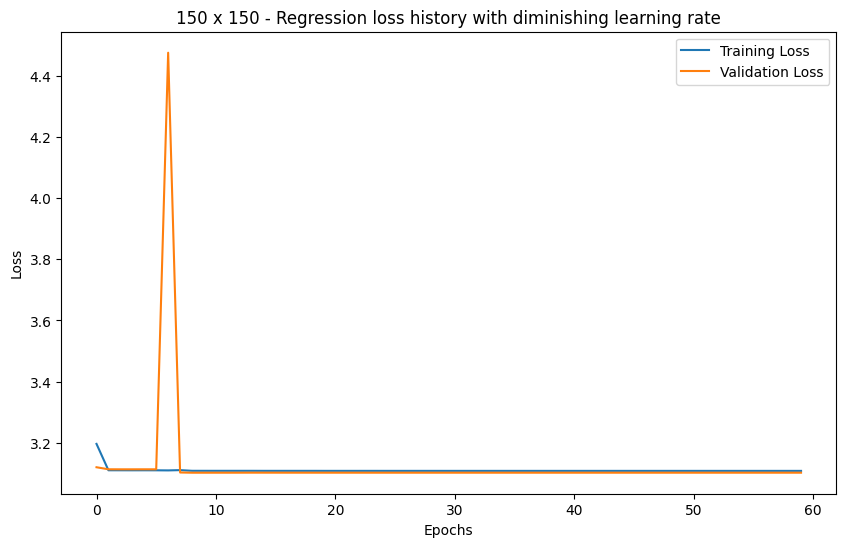

In [ ]:
# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'{img_rows} x {img_cols} - Regression loss history with diminishing learning rate')
plt.legend()
plt.show()
plt.close()

In [ ]:
y_pred = model.predict(x_test)

2024-11-07 15:33:38.788744: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 16 bytes spill stores, 16 bytes spill loads



57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step


In [ ]:
y_pred_hours = np.argmax(y_pred[0], axis=1)
y_test_hours = y_test[:,0]

abs_hr = np.abs(y_pred_hours - y_test_hours)
cse_hr = np.minimum(abs_hr, 12 - abs_hr)

Text(0.5, 1.0, 'Scatter for hour - Classification')

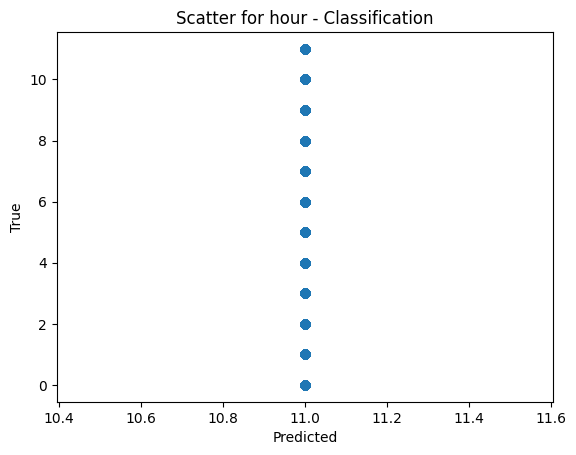

In [ ]:
plt.scatter(y_pred_hours, y_test_hours)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for hour - Classification')

In [ ]:
y_test_minutes =  y_test[:,1]
y_pred_mins = (np.arctan2(y_pred[1][:,1], y_pred[1][:,0]) % (2 * np.pi)) *  60 / (2 * np.pi)


abs_mins = abs(y_pred_mins-y_test[:,1])
cse_min = np.minimum(abs_mins, 60. - abs_mins)

Text(0.5, 1.0, 'Scatter for minutes - Polar')

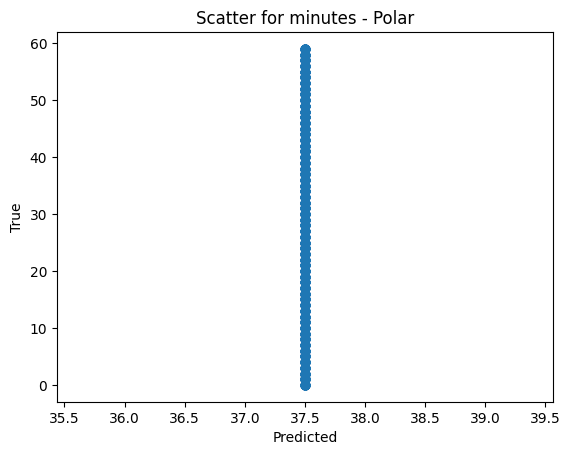

In [ ]:
plt.scatter(y_pred_mins, y_test[:,1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for minutes - Polar')

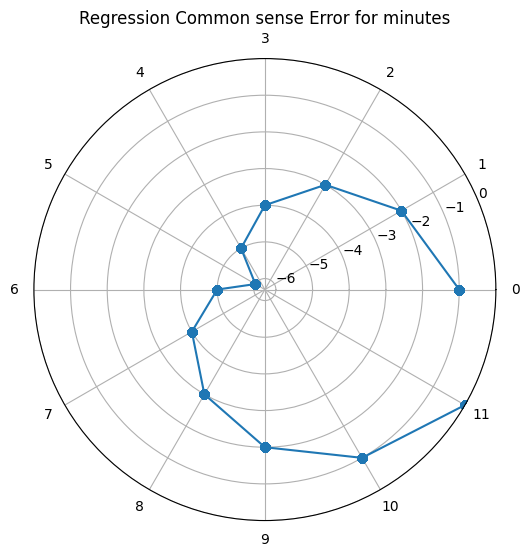

In [ ]:
sorted_indices_hr = np.argsort(y_test_hours)
sorted_y_test_hr = y_test_hours[sorted_indices_hr]

# Create polar plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_hr/12, -cse_hr[sorted_indices_hr], marker='o')

# Add title and show plot
ax.set_title("Regression Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 12, endpoint=False)  # 12 hours around the clock
ax.set_xticks(theta_ticks)

ax.set_xticklabels(range(12))

plt.show()

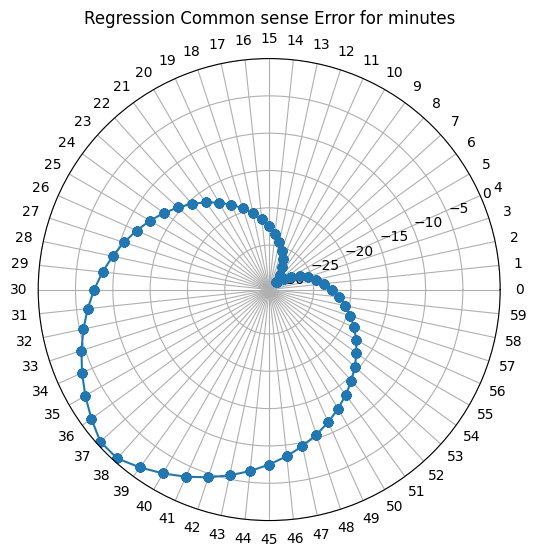

In [ ]:
sorted_indices_min = np.argsort(y_test_minutes)
sorted_y_test_min = y_test_minutes[sorted_indices_min]

# Create polar plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_min/60, -cse_min[sorted_indices_min], marker='o')

# Add title and show plot
ax.set_title("Regression Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 60, endpoint=False)  # 60 mins around the clock
ax.set_xticks(theta_ticks)

ax.set_xticklabels(range(60))

plt.show()